In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import calendar
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.ticker as mtick
import statsmodels.api as sm
import warnings
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import time
from scipy.stats import spearmanr
import statsmodels.api as sm


In [80]:
df = pd.read_csv('hotel_bookings_clean.csv', parse_dates=['arrival_date'])

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118087 entries, 0 to 118086
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118087 non-null  object        
 1   is_canceled                     118087 non-null  bool          
 2   lead_time                       118087 non-null  int64         
 3   arrival_date_month              118087 non-null  object        
 4   stays_in_weekend_nights         118087 non-null  int64         
 5   stays_in_week_nights            118087 non-null  int64         
 6   adults                          118087 non-null  int64         
 7   children                        118087 non-null  int64         
 8   babies                          118087 non-null  int64         
 9   meal                            118087 non-null  object        
 10  market_segment                  118087 non-null  object 

In [82]:
print(df['reservation_status'].value_counts())

reservation_status
Check-Out    73973
Canceled     42925
No-Show       1189
Name: count, dtype: int64


In [83]:
cancelations = (df['reservation_status'] == 'Canceled').sum()
print(cancelations)

42925


In [84]:
total_bookings = df.shape[0]
print(total_bookings)

118087


In [85]:
cancelation_rate = cancelations / total_bookings
print(cancelation_rate)

0.36350317985891756


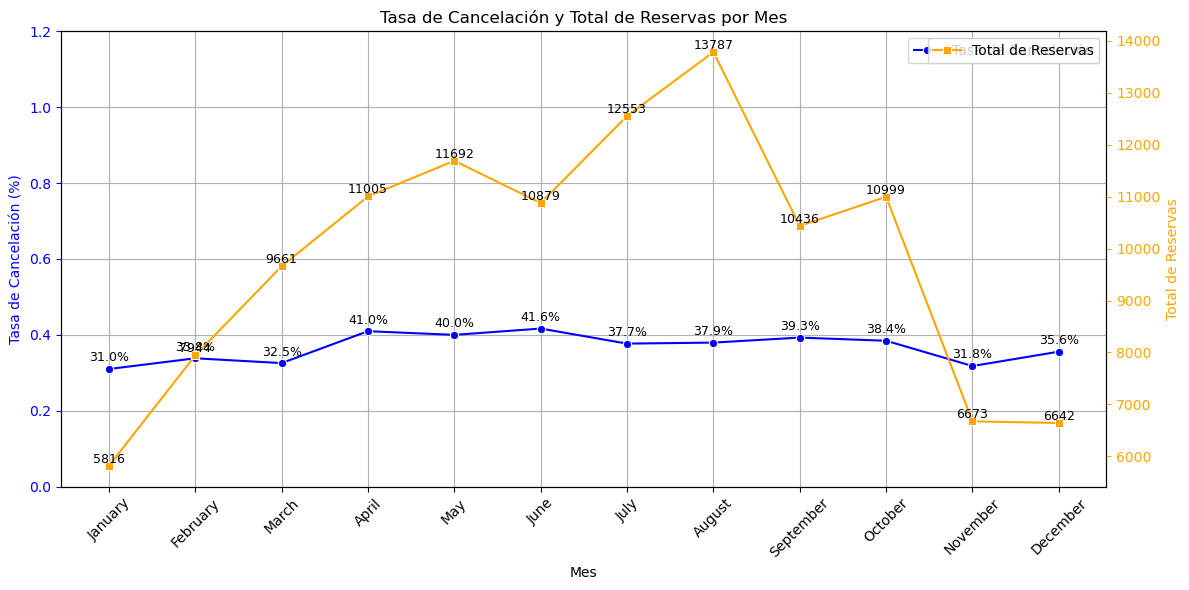

In [86]:
# 2. Asegurar orden correcto de meses y convertir en categoría ordenada
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
df['arrival_date_month'] = pd.Categorical(
    df['arrival_date_month'],
    categories=month_order,
    ordered=True
)

# 3. Cálculo de tasa de cancelación y total de reservas por mes
monthly = (
    df
    .groupby('arrival_date_month', observed=False)  # evita el FutureWarning
    .agg(
        cancellation_rate=('is_canceled', 'mean'),
        total_reservations=('is_canceled', 'size')
    )
    .reset_index()
)

# 4. Gráfico con doble eje Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# 4a. Tasa de cancelación (eje izquierdo)
sns.lineplot(
    ax=ax1,
    data=monthly,
    x='arrival_date_month',
    y='cancellation_rate',
    marker='o',
    color='blue',
    label='Tasa de Cancelación'
)
# Etiquetas de porcentaje
for idx, row in monthly.iterrows():
    ax1.text(
        idx,
        row.cancellation_rate + 0.02,
        f"{row.cancellation_rate*100:.1f}%",
        ha='center',
        fontsize=9,
        color='black'
    )
ax1.set_ylabel('Tasa de Cancelación (%)', color='blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylim(0, 1.2)

# 4b. Total de reservas (eje derecho)
ax2 = ax1.twinx()
sns.lineplot(
    ax=ax2,
    data=monthly,
    x='arrival_date_month',
    y='total_reservations',
    marker='s',
    color='orange',
    label='Total de Reservas'
)
# Etiquetas de total de reservas
for idx, row in monthly.iterrows():
    ax2.text(
        idx,
        row.total_reservations,
        f"{row.total_reservations}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
ax2.set_ylabel('Total de Reservas', color='orange')
ax2.tick_params(axis='y', colors='orange')

# 5. Personalización común
ax1.set_xlabel('Mes')
plt.title('Tasa de Cancelación y Total de Reservas por Mes')
ax1.set_xticks(range(len(monthly)))
ax1.set_xticklabels(monthly['arrival_date_month'], rotation=45)
ax1.grid(True)

plt.tight_layout()
plt.show()

Coeficiente de correlación (reservas vs tasa de cancelación): 0.574


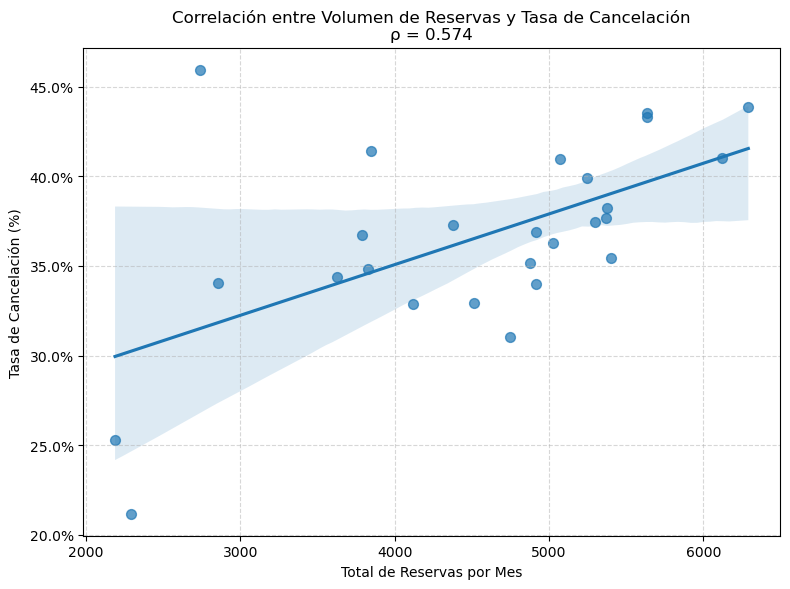

In [87]:
# 1. Carga y asegurarte de que arrival_date esté en datetime
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Agrupar por mes (PeriodIndex) y calcular:
#    - total_reservations: cuenta de filas (reservas)
#    - cancellation_rate: media de is_canceled
monthly = (
    df
    .groupby(df['arrival_date'].dt.to_period('M'), observed=False)
    .agg(
        total_reservations=('is_canceled','size'),
        cancellation_rate=('is_canceled','mean')
    )
    .reset_index()
)
# convertir el Period a timestamp para trazar
monthly['month'] = monthly['arrival_date'].dt.to_timestamp()

# 3. Correlación de Pearson
corr_value = monthly['total_reservations'].corr(monthly['cancellation_rate'])
print(f"Coeficiente de correlación (reservas vs tasa de cancelación): {corr_value:.3f}")

# 4. Scatter + línea de regresión
plt.figure(figsize=(8,6))
sns.regplot(
    data=monthly,
    x='total_reservations',
    y='cancellation_rate',
    marker='o',
    scatter_kws={'s':50, 'alpha':0.7}
)
plt.xlabel('Total de Reservas por Mes')
plt.ylabel('Tasa de Cancelación (%)')
plt.title('Correlación entre Volumen de Reservas y Tasa de Cancelación\n'
          f'ρ = {corr_value:.3f}')
# formatear eje Y en %
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


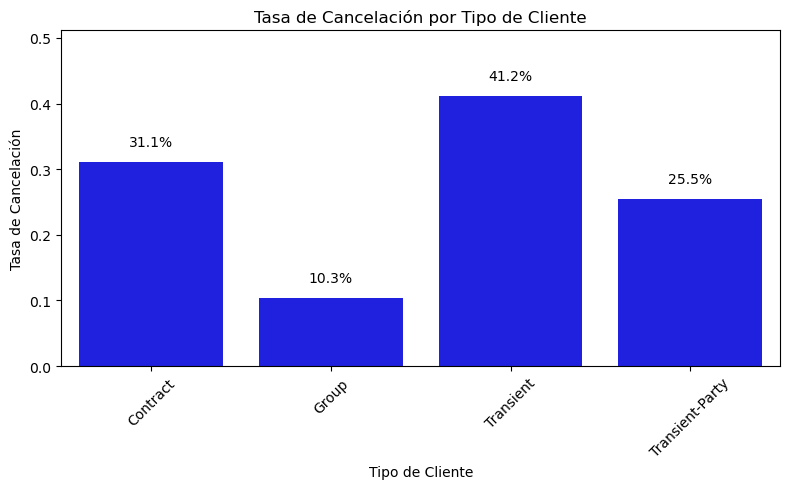

In [88]:
# (Recalcula customer_type_cancellation con observed=False para evitar el FutureWarning:)
customer_type_cancellation = (
    df.groupby('customer_type', observed=False)
      .agg(total_bookings=('is_canceled','count'),
           cancellations=('is_canceled','sum'))
)
customer_type_cancellation['cancellation_rate'] = (
    customer_type_cancellation['cancellations']
    / customer_type_cancellation['total_bookings']
)

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(
    x=customer_type_cancellation.index,
    y='cancellation_rate',
    data=customer_type_cancellation,
    color='blue',
    ax=ax
)
ax.set_title('Tasa de Cancelación por Tipo de Cliente')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Tasa de Cancelación')
ax.set_ylim(0, customer_type_cancellation['cancellation_rate'].max() + 0.1)
plt.xticks(rotation=45)

# Añadir etiquetas de datos sobre cada barra:
for patch in ax.patches:
    height = patch.get_height()
    x_pos = patch.get_x() + patch.get_width()/2
    ax.text(
        x_pos,
        height + 0.02,
        f"{height*100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()



## Distribucion cancelaciones por tipo de deposito

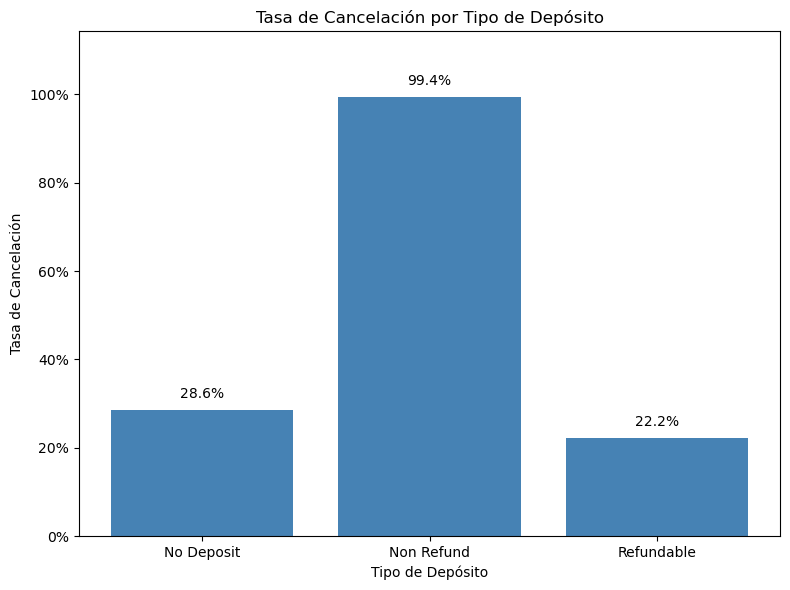

In [89]:
# 2. Agrupar por tipo de depósito y calcular tasa de cancelación
deposit = (
    df
    .groupby('deposit_type', observed=False)
    .agg(
        total=('is_canceled', 'size'),
        canceled=('is_canceled', 'sum')
    )
    .reset_index()
)
deposit['cancel_rate'] = deposit['canceled'] / deposit['total']

# 3. Dibujar el barplot con Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    deposit['deposit_type'],
    deposit['cancel_rate'],
    color='steelblue'
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(0, deposit['cancel_rate'].max() * 1.15)

# 5. Anotar porcentajes encima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + 0.02,
        f"{h * 100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# 6. Etiquetas y título
ax.set_xlabel('Tipo de Depósito')
ax.set_ylabel('Tasa de Cancelación')
ax.set_title('Tasa de Cancelación por Tipo de Depósito')

plt.tight_layout()
plt.show()

## Evolucion del adr en funcion del customer_type (de las reservas canceladas)

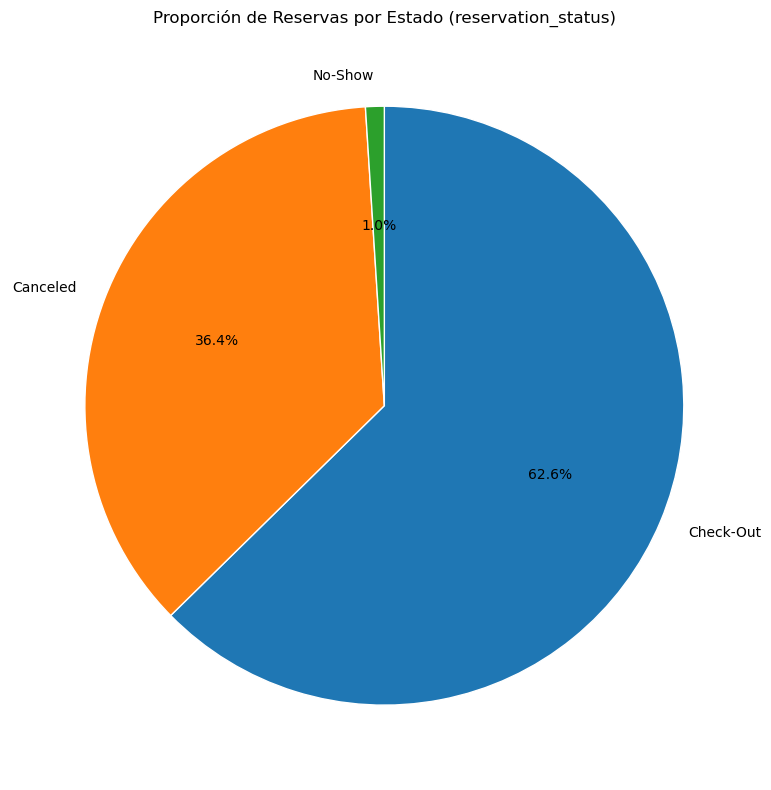

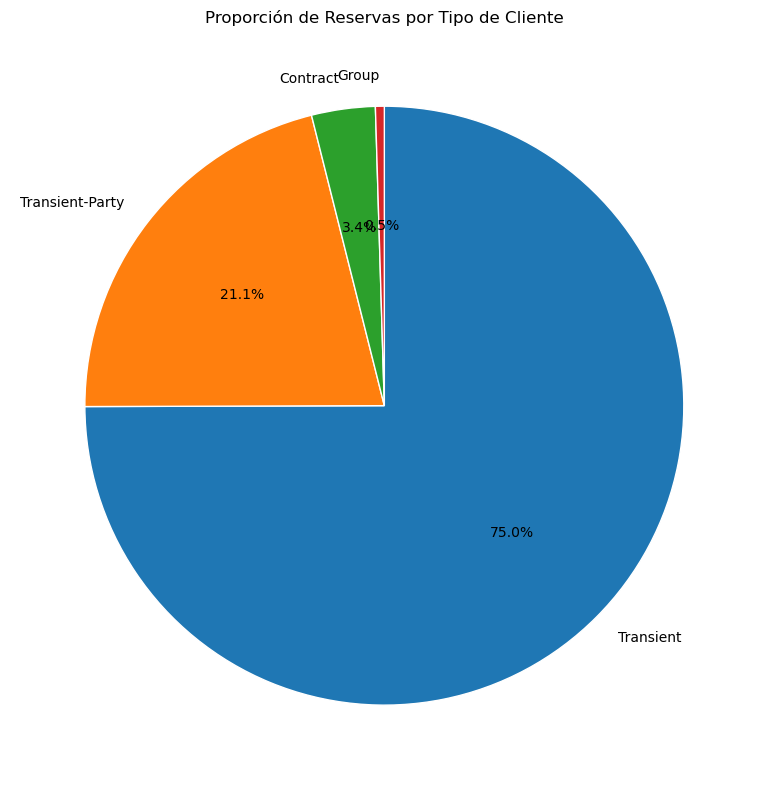

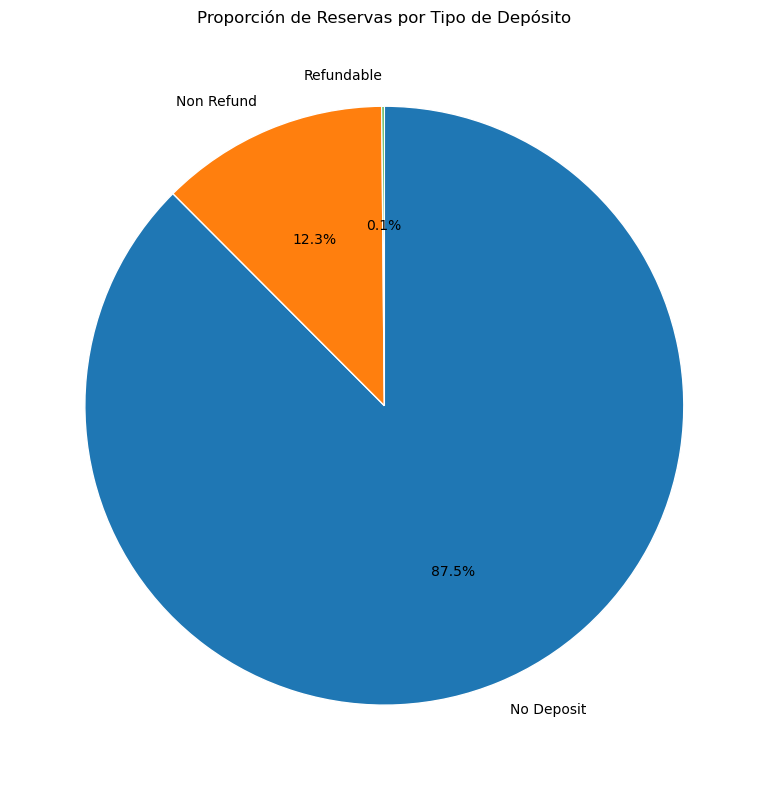

In [90]:
# 1. Conteo de reservation_status
status_counts = df['reservation_status'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Estado (reservation_status)')
plt.tight_layout()
plt.show()

################################################################################

# 2. Conteo de customer_type
type_counts = df['customer_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Cliente')
plt.tight_layout()
plt.show()

################################################################################

# 2. Conteo de deposit_type
deposit_counts = df['deposit_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    deposit_counts,
    labels=deposit_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Depósito')
plt.tight_layout()
plt.show()


## Análisis bivariante: cancelación vs. otras variables

Variables categóricas

    Segmento de cliente (market_segment), tipo de hotel (hotel), tipo de cliente (customer_type), depósito (deposit_type).

    Cruza cada variable con is_canceled y calcula tasas; visualiza con barras apiladas o mosaicos.

    Test de chi-cuadrado en cada cruce.

Variables numéricas

    lead_time, adr (tarifa diaria), stays_in_weekend_nights, etc.

    Boxplots de cada variable separados por canceled=True/False.

    Correlación de punto biserial o U de Mann–Whitney para ver si los distribuciones difieren.

### Variables categóricas


=== Variable: market_segment ===



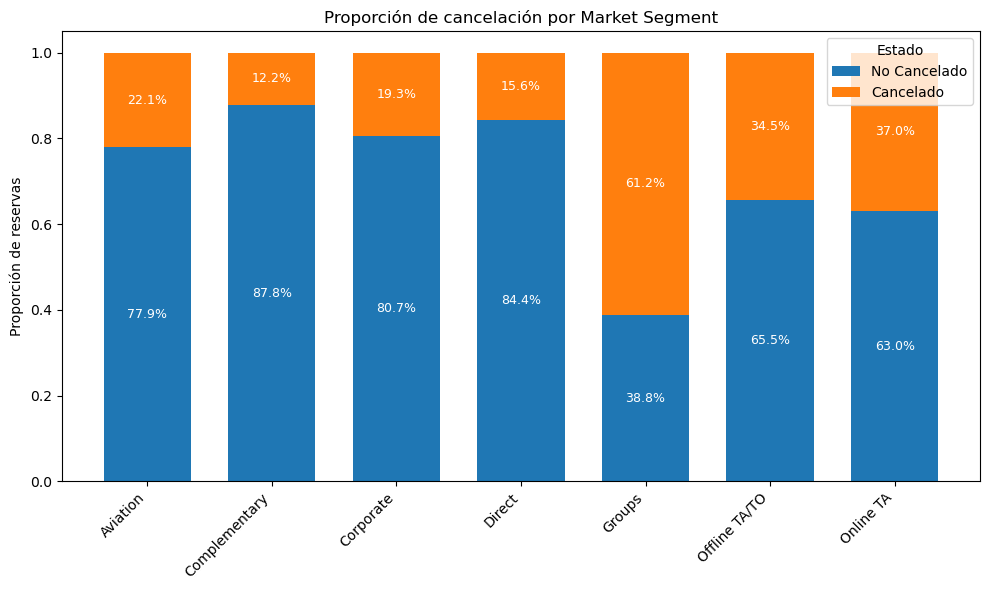

Chi² = 8302.35, p-valor = 0.0000 → Significativo


=== Variable: hotel ===



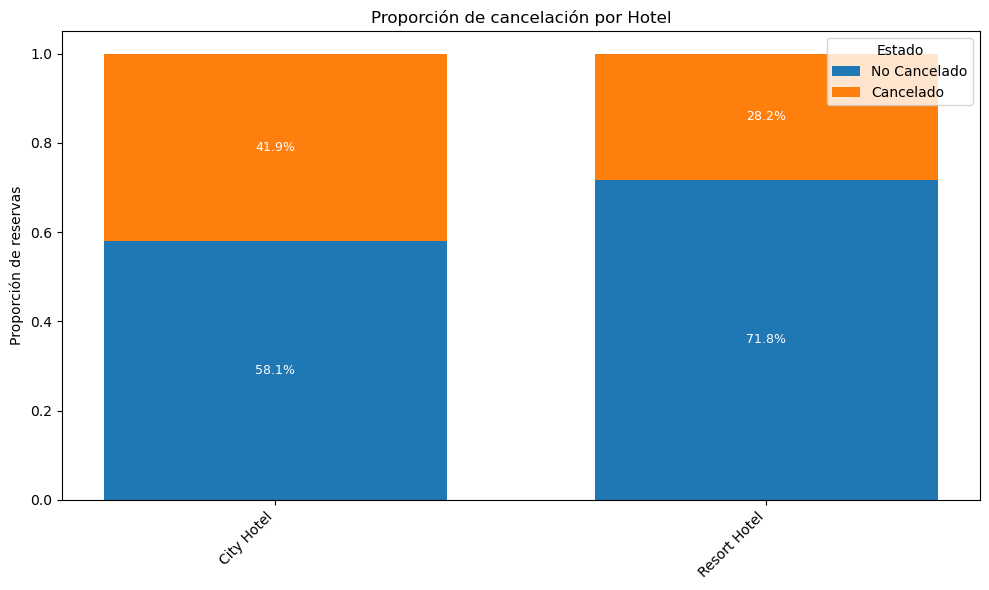

Chi² = 2091.00, p-valor = 0.0000 → Significativo


=== Variable: customer_type ===



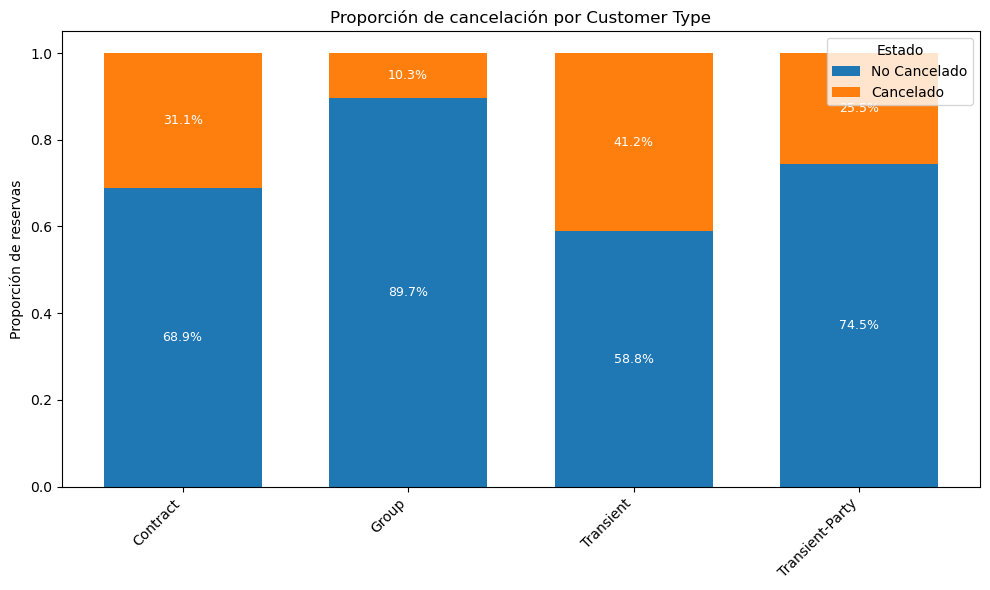

Chi² = 2286.54, p-valor = 0.0000 → Significativo


=== Variable: deposit_type ===



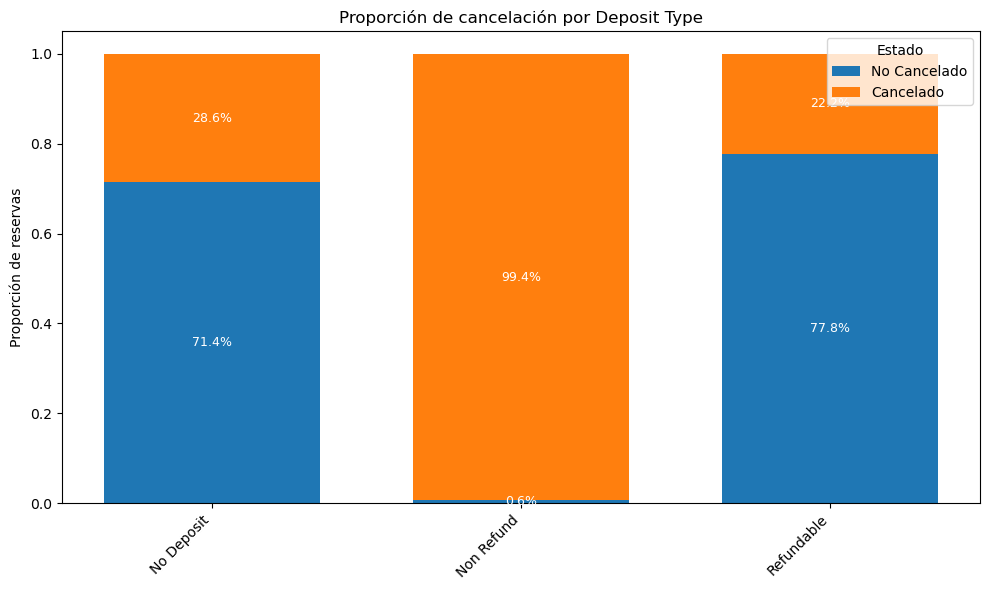

Chi² = 27312.75, p-valor = 0.0000 → Significativo



In [91]:
# 4.1 Análisis bivariante: cancelación vs. variables categóricas

# 0) Carga del CSV y mapeo de la columna de cancelación a texto

df['cancel_label'] = df['is_canceled'].map({False: 'No Cancelado', True: 'Cancelado'})

categorical_vars = ['market_segment', 'hotel', 'customer_type', 'deposit_type']

for var in categorical_vars:
    print(f"\n=== Variable: {var} ===\n")
    
    # 1) Crosstab usando la etiqueta de texto
    ct = pd.crosstab(df[var], df['cancel_label'])
    
    # 2) Proporciones por fila
    ct_prop = ct.div(ct.sum(axis=1), axis=0)
    
    # 3) Gráfico de barras apiladas manual con etiquetas de porcentaje
    labels    = ct_prop.index.tolist()
    no_cancel = ct_prop['No Cancelado'].values
    cancel    = ct_prop['Cancelado'].values
    x         = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, no_cancel, width=0.7, label='No Cancelado')
    ax.bar(x, cancel,    width=0.7, bottom=no_cancel, label='Cancelado')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Proporción de reservas')
    ax.set_title(f'Proporción de cancelación por {var.replace("_", " ").title()}')
    ax.legend(title='Estado', loc='upper right')
    
    # Añadir etiqueta de porcentaje en cada segmento
    for i in range(len(x)):
        if no_cancel[i] > 0:
            ax.text(x[i], no_cancel[i] / 2,
                    f"{no_cancel[i]:.1%}",
                    ha='center', va='center', fontsize=9, color='white')
        if cancel[i] > 0:
            ax.text(x[i], no_cancel[i] + cancel[i] / 2,
                    f"{cancel[i]:.1%}",
                    ha='center', va='center', fontsize=9, color='white')
    plt.tight_layout()
    plt.show()
    
    # 5) Test de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Chi² = {chi2:.2f}, p-valor = {p:.4f} → "
          + ("Significativo" if p < 0.05 else "No significativo") + "\n")


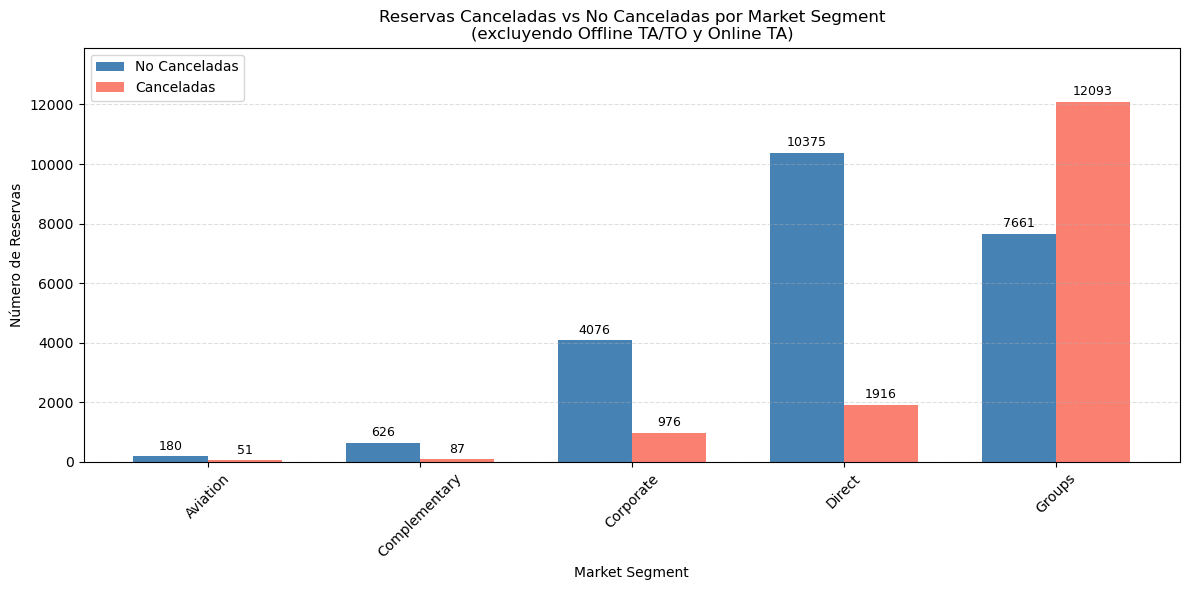

In [92]:
# 2. Filtrar excluyendo Offline TA/TO y Online TA
exclude_segments = ['Offline TA/TO', 'Online TA']
df_f = df[~df['market_segment'].isin(exclude_segments)].copy()

# 3. Contar reservas por market_segment y estado de cancelación
counts = (
    df_f
    .groupby(['market_segment', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'No Canceladas', 1: 'Canceladas'})
    .reset_index()
)

# 4. Preparar posiciones y anchuras
n_segments = len(counts)
x = np.arange(n_segments)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# 5. Dibujar barras side-by-side
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 6. Anotar valores encima de cada barra
max_height = counts[['No Canceladas','Canceladas']].values.max()
for bar in list(bars_no) + list(bars_yes):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max_height*0.01,
        f"{int(h)}",
        ha='center', va='bottom',
        fontsize=9
    )

# 7. Etiquetas y estilo
ax.set_xlabel('Market Segment')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas Canceladas vs No Canceladas por Market Segment\n(excluyendo Offline TA/TO y Online TA)')
ax.set_xticks(x)
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [93]:
# Ajustes opcionales de estilo
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

# %%

# Aseguramos datetime
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Creamos duración total de estancia si no existiera
if 'total_length_of_stay' not in df.columns:
    df['total_length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']


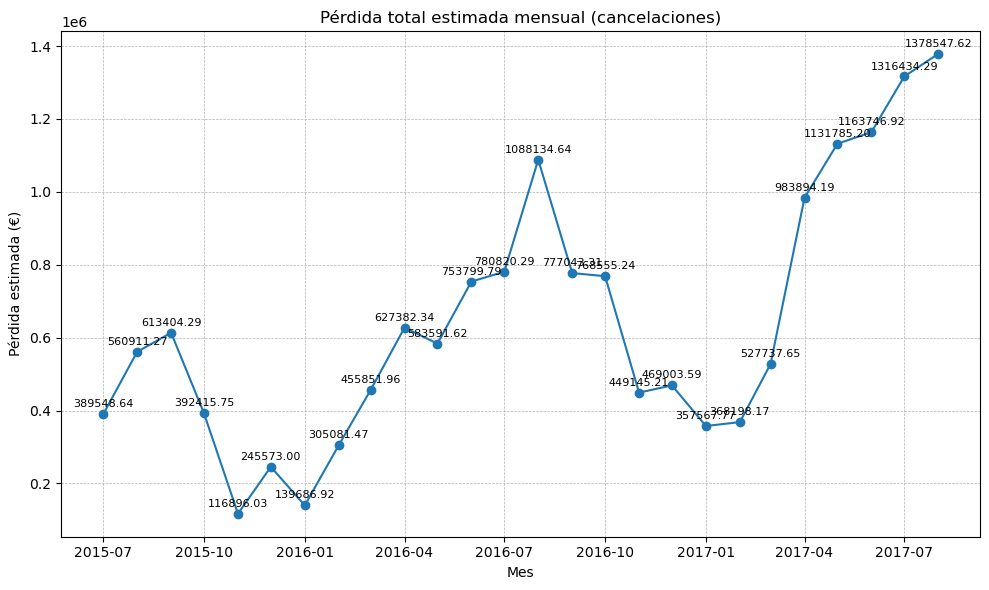

In [94]:
# ## 2. Pérdida total mensual por cancelaciones

# %%
# Filtramos canceladas y calculamos pérdida por reserva
df_canc = df[df['is_canceled'] == True].copy()
df_canc['loss'] = df_canc['adr'] * df_canc['total_length_of_stay']

# Agrupamos y sumamos por mes-año
monthly_loss = (
    df_canc
    .groupby(df_canc['arrival_date'].dt.to_period('M'))['loss']
    .sum()
    .to_timestamp()
)

# %%
# Gráfico de línea
fig, ax = plt.subplots()
ax.plot(monthly_loss.index, monthly_loss.values, marker='o')
ax.set_title('Pérdida total estimada mensual (cancelaciones)')
ax.set_xlabel('Mes')
ax.set_ylabel('Pérdida estimada (€)')
ax.grid(True, linestyle='--', linewidth=0.5)

# Anotamos cada punto
for x, y in zip(monthly_loss.index, monthly_loss.values):
    ax.annotate(f"{y:.2f}", (x, y),
                textcoords="offset points", xytext=(0,5),
                ha='center', fontsize=8)
plt.tight_layout()
plt.show()

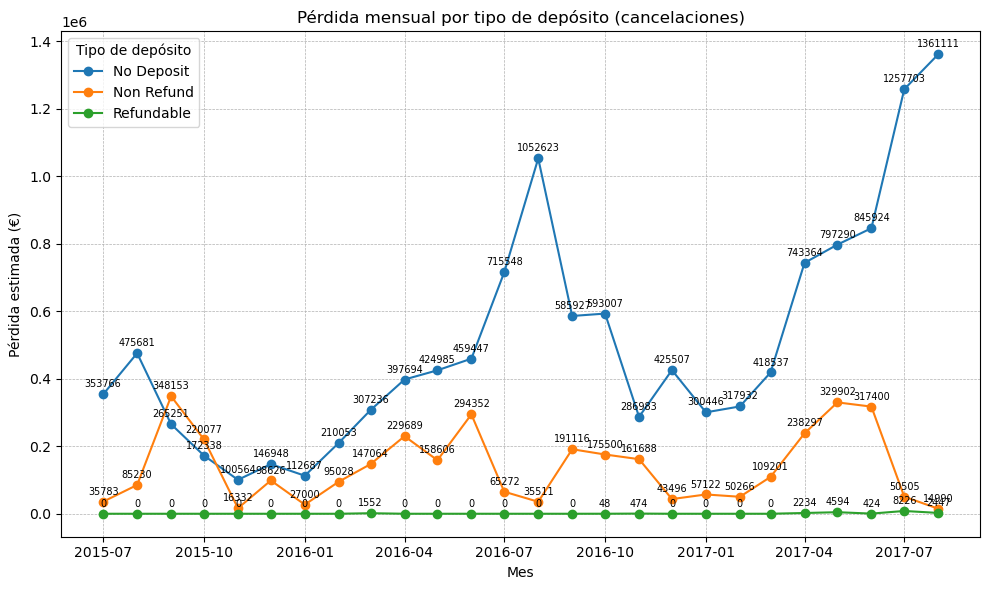

In [95]:
# %% [markdown]
# ## 3. Pérdida mensual desglosada por tipo de depósito

# %%
# Aseguramos etiqueta de depósito
df_canc['deposit_type'] = df_canc['deposit_type'].astype(str)

# Agrupamos por mes y deposit_type
monthly_loss_dep = (
    df_canc
    .groupby([df_canc['arrival_date'].dt.to_period('M'), 'deposit_type'])['loss']
    .sum()
    .unstack('deposit_type')
    .fillna(0)
    .to_timestamp()
)

# %%
# Gráfico de línea por depósito
fig, ax = plt.subplots()
for dep in monthly_loss_dep.columns:
    ax.plot(monthly_loss_dep.index, monthly_loss_dep[dep],
            marker='o', label=dep)
ax.set_title('Pérdida mensual por tipo de depósito (cancelaciones)')
ax.set_xlabel('Mes')
ax.set_ylabel('Pérdida estimada (€)')
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend(title='Tipo de depósito')

# Anotamos cada punto por curva
for dep in monthly_loss_dep.columns:
    for x, y in zip(monthly_loss_dep.index, monthly_loss_dep[dep]):
        ax.annotate(f"{y:.0f}", (x, y),
                    textcoords="offset points", xytext=(0,5),
                    ha='center', fontsize=7)
plt.tight_layout()
plt.show()


In [96]:
# Código para realizar los tests uno por uno

df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['mes'] = df['arrival_date'].dt.month
# Calculamos la tasa de cancelación mensual para regresión
monthly_rate = df.groupby('mes')['is_canceled'].mean()

# 1) Chi‑cuadrado de independencia (mes × cancelación)
ct = pd.crosstab(df['mes'], df['is_canceled'])
chi2, p_chi, dof, expected = stats.chi2_contingency(ct)
print("=== Chi‑cuadrado de independencia ===")
print(f"Chi2 = {chi2:.2f}, p‑valor = {p_chi:.4f}\n")

# 2) ANOVA unifactorial sobre tasa de cancelación
groups = [grp['is_canceled'].values for _, grp in df.groupby('mes')]
f_stat, p_anova = stats.f_oneway(*groups)
print("=== ANOVA unifactorial ===")
print(f"F = {f_stat:.2f}, p‑valor = {p_anova:.4f}\n")

# 3) Prueba de tendencia: Kendall Tau
#tau, p_tau = stats.kendalltau(monthly_rate.index, monthly_rate.values)
#print("=== Tendencia (Kendall Tau) ===")
#print(f"Tau = {tau:.3f}, p‑valor = {p_tau:.4f}\n")

# 4) Regresión lineal simple sobre tasa vs. mes
X = sm.add_constant(monthly_rate.index)
model = sm.OLS(monthly_rate.values, X).fit()
print("=== Regresión lineal sobre tasa vs. mes ===")
print(model.summary())


=== Chi‑cuadrado de independencia ===
Chi2 = 542.76, p‑valor = 0.0000

=== ANOVA unifactorial ===
F = 49.56, p‑valor = 0.0000

=== Regresión lineal sobre tasa vs. mes ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3627
Date:                Fri, 02 May 2025   Prob (F-statistic):              0.560
Time:                        15:20:43   Log-Likelihood:                 23.319
No. Observations:                  12   AIC:                            -42.64
Df Residuals:                      10   BIC:                            -41.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err       

In [97]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['mes'] = df['arrival_date'].dt.month

# 2) Tasa mensual de cancelación
monthly_rate = df.groupby('mes')['is_canceled'].mean()

# 3) Chi-cuadrado mes × cancelación
ct = pd.crosstab(df['mes'], df['is_canceled'])
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)
print("Chi2 test:", chi2, "p-valor:", p_chi)

# 4) ANOVA unifactorial
groups = [g['is_canceled'].values for _, g in df.groupby('mes')]
F, p_anova = stats.f_oneway(*groups)
print("ANOVA F-stat:", F, "p-valor:", p_anova)

# 5) Prueba de tendencia (Kendall)
tau, p_tau = stats.kendalltau(monthly_rate.index, monthly_rate.values)
print("Kendall Tau:", tau, "p-valor:", p_tau)

# 6) Regresión lineal de tasa vs mes
X = sm.add_constant(monthly_rate.index)
model = sm.OLS(monthly_rate.values, X).fit()

#  ——> Aquí filtramos el warning de kurtosistest:
warnings.filterwarnings(
    "ignore",
    message=".*kurtosistest only valid for n>=20.*",
    category=UserWarning
)

print(model.summary())


Chi2 test: 542.7641641398702 p-valor: 2.3974650825962615e-109
ANOVA F-stat: 49.564998561134935 p-valor: 1.3180254277582658e-109
Kendall Tau: 0.0606060606060606 p-valor: 0.8405883696421891
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3627
Date:                Fri, 02 May 2025   Prob (F-statistic):              0.560
Time:                        15:20:43   Log-Likelihood:                 23.319
No. Observations:                  12   AIC:                            -42.64
Df Residuals:                      10   BIC:                            -41.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

A partir de los resultados:

    Chi-cuadrado de independencia

        Estadístico: χ² = 542.76, p-valor < 0.0001

        Interpretación: Rechazamos la H₀ (“la probabilidad de cancelación es la misma en todos los meses”). Hay evidencia muy fuerte de que el mes del año y la probabilidad de cancelación están asociados.

    ANOVA unifactorial

        F = 49.56, p-valor < 0.0001

        Interpretación: También aquí rechazamos la H₀ (“las medias de la tasa de cancelación son iguales para todos los meses”). Los promedios de cancelación difieren significativamente entre meses.

    Tendencia (Kendall Tau)

        Tau = 0.061, p-valor = 0.8406

        Interpretación: No hay evidencia de una tendencia monótona (ni creciente ni decreciente) en la tasa de cancelación a lo largo del año.

    Regresión lineal tasa vs. mes

        Intercepto ≈ 0.355 (p<0.001)

        Pendiente ≈ 0.0019 (p = 0.56)

        R² ≈ 0.035

        Interpretación: El coeficiente de mes no es significativo (p=0.56), confirmando que no existe una tendencia lineal clara en la tasa de cancelación a lo largo de los meses.

#### Conclusión global
#### Hay variación estacional: ciertas épocas del año tienen cancelaciones muy distintas (Chi-cuadrado y ANOVA lo confirman).
#### Sin embargo, no existe una tendencia lineal ni monótona de aumento o disminución de cancelaciones mes a mes durante el período analizado.
#### En la práctica: deberías centrarte en identificar meses pico y quizá investigar qué factores (vacaciones, temporada alta, políticas de precios) explican esas diferencias estacionales, más que buscar un patrón de crecimiento o decrecimiento a lo largo del tiempo.

Incentivar reservas last-minute (
    coste medio o % de lo que se deberia cobrar si cancela

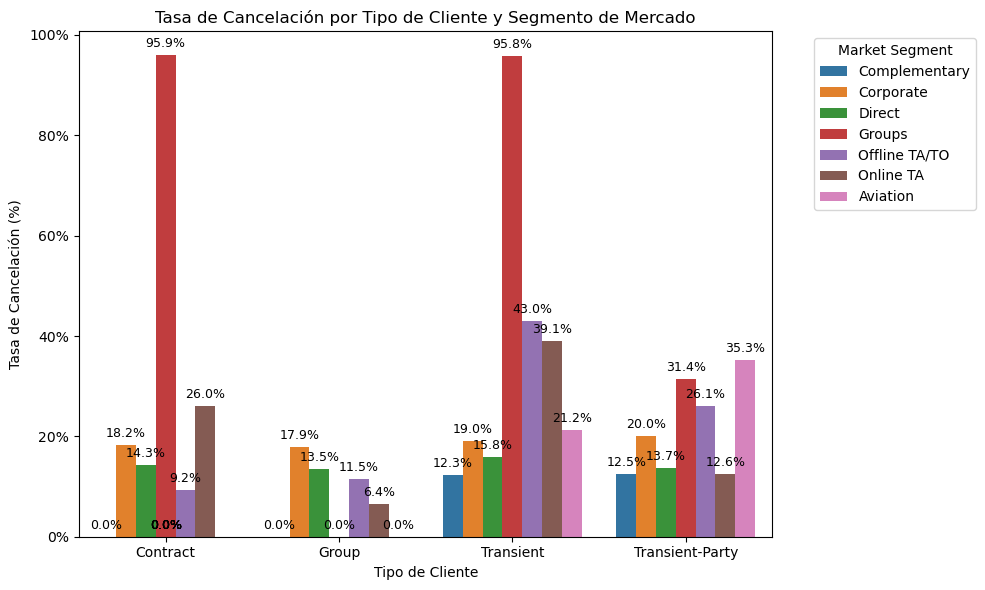

In [98]:
# 2. Agrupar por customer_type y market_segment
summary = (
    df
    .groupby(['customer_type', 'market_segment'], observed=False)
    .agg(
        total_reservas=('is_canceled', 'size'),
        cancelaciones=('is_canceled', 'sum'),
        tasa_cancelacion=('is_canceled', 'mean')
    )
    .reset_index()
)

# 3. Gráfico de barras con seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=summary,
    x='customer_type',
    y='tasa_cancelacion',
    hue='market_segment',
    ax=ax
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylabel('Tasa de Cancelación (%)')

# 5. Añadir etiquetas de datos en cada barra
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax.text(
        x, 
        height + 0.01, 
        f"{height*100:.1f}%", 
        ha='center', 
        va='bottom',
        fontsize=9
    )

# 6. Ajustes finales
ax.set_xlabel('Tipo de Cliente')
ax.set_title('Tasa de Cancelación por Tipo de Cliente y Segmento de Mercado')
plt.xticks(rotation=0)
plt.legend(title='Market Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

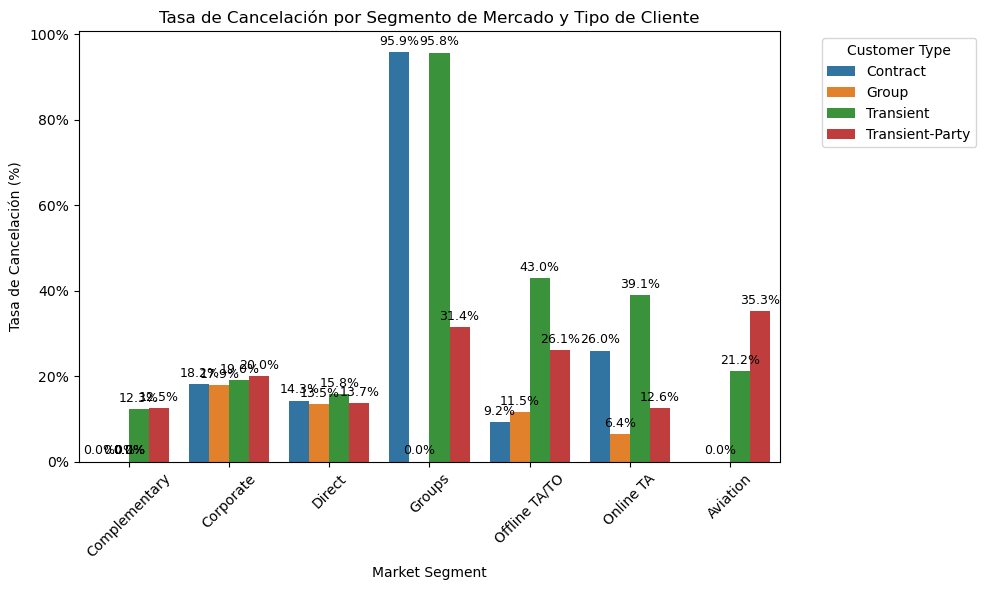

In [99]:


# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Agrupar por customer_type y market_segment
summary = (
    df
    .groupby(['customer_type', 'market_segment'], observed=False)
    .agg(
        total_reservas=('is_canceled', 'size'),
        cancelaciones=('is_canceled', 'sum'),
        tasa_cancelacion=('is_canceled', 'mean')
    )
    .reset_index()
)

# 3. Gráfico de barras intercambiando customer_type y market_segment
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=summary,
    x='market_segment',        # ahora el eje X es market_segment
    y='tasa_cancelacion',
    hue='customer_type',       # y cada barra se hue por customer_type
    ax=ax
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylabel('Tasa de Cancelación (%)')
ax.set_xlabel('Market Segment')

# 5. Añadir etiquetas de datos en cada barra
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax.text(
        x, 
        height + 0.01, 
        f"{height*100:.1f}%", 
        ha='center', 
        va='bottom',
        fontsize=9
    )

# 6. Ajustes finales
ax.set_title('Tasa de Cancelación por Segmento de Mercado y Tipo de Cliente')
plt.xticks(rotation=45)
plt.legend(title='Customer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_124350/3276742668.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



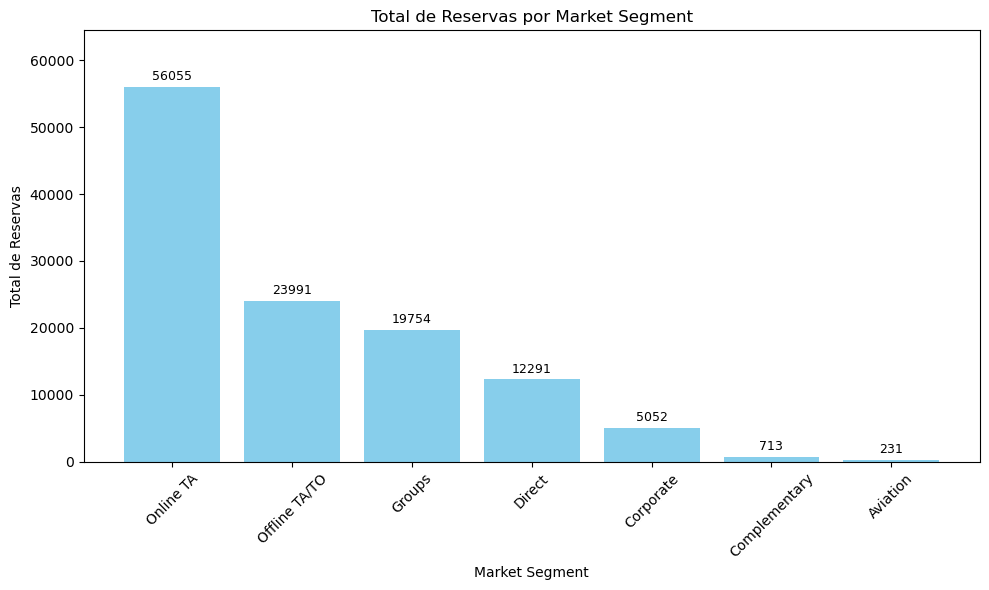

In [100]:
# 2. Contar reservas por market_segment
counts = (
    df
    .groupby('market_segment', observed=False)
    .size()
    .reset_index(name='total_reservations')
    .sort_values('total_reservations', ascending=False)
)

# 3. Gráfico de barras con Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    counts['market_segment'],
    counts['total_reservations'],
    color='skyblue'
)

# 4. Anotar valores encima de cada barra
max_val = counts['total_reservations'].max()
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + max_val*0.01,
        f"{height}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 5. Etiquetas y estilo
ax.set_title('Total de Reservas por Market Segment')
ax.set_xlabel('Market Segment')
ax.set_ylabel('Total de Reservas')
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.set_ylim(0, max_val * 1.15)
plt.tight_layout()
plt.show()


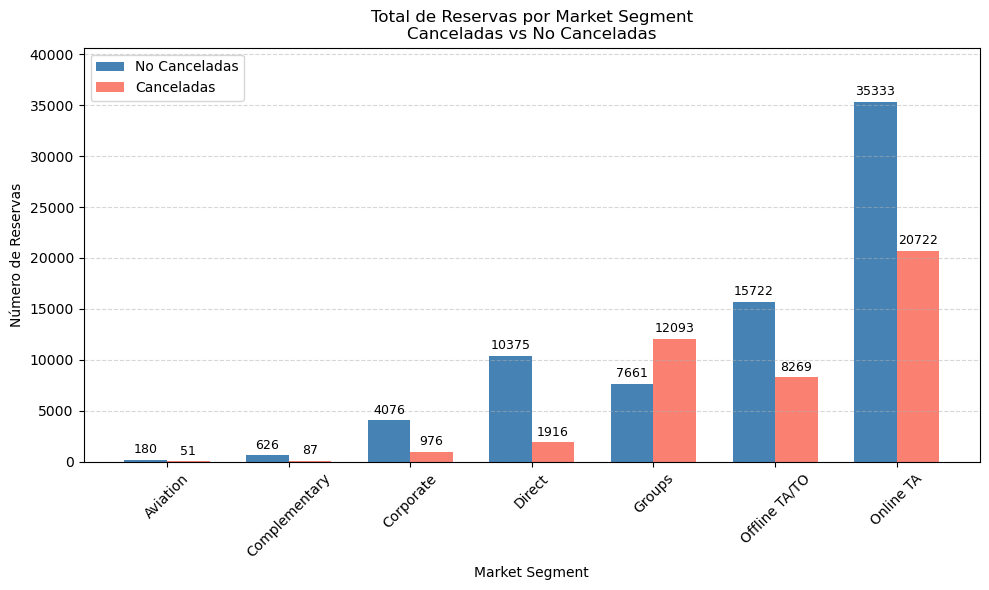

In [101]:
# 2. Conteo de reservas por market_segment y estado de cancelación
counts = (
    df
    .groupby(['market_segment', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
)
# Renombrar columnas para legibilidad
counts = counts.rename(columns={0: 'No Canceladas', 1: 'Canceladas'}).reset_index()

# 3. Configuración de posición de barras
x = np.arange(len(counts))           # posición de cada grupo en el eje X
width = 0.35                         # ancho de cada barra

fig, ax = plt.subplots(figsize=(10, 6))

# 4. Dibujar barras
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 5. Anotar valores encima de cada barra
for bar in bars_no + bars_yes:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + counts[['No Canceladas','Canceladas']].values.max() * 0.01,
        f"{int(h)}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 6. Etiquetas y estilo
ax.set_xlabel('Market Segment')
ax.set_ylabel('Número de Reservas')
ax.set_title('Total de Reservas por Market Segment\nCanceladas vs No Canceladas')
ax.set_xticks(x)
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, counts[['No Canceladas','Canceladas']].values.max() * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


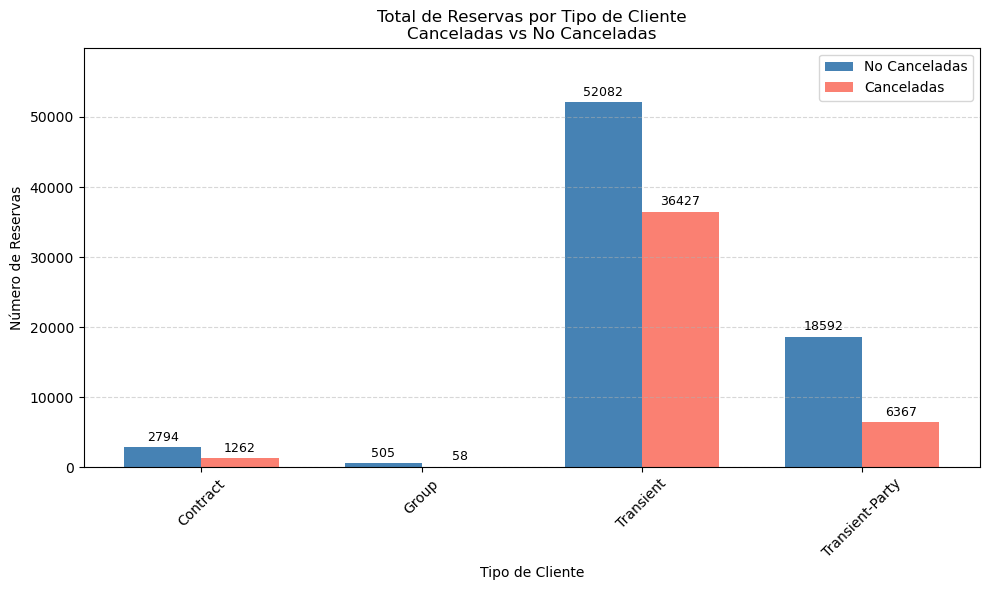

In [102]:
# 2. Conteo de reservas por customer_type y estado de cancelación
counts = (
    df
    .groupby(['customer_type', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
)
# Renombrar columnas para legibilidad
counts = counts.rename(columns={0: 'No Canceladas', 1: 'Canceladas'}).reset_index()

# 3. Configuración de posiciones en el eje X
x = np.arange(len(counts))   # posiciones para cada customer_type
width = 0.35                 # ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# 4. Dibujar barras side-by-side
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 5. Anotar valores encima de cada barra
max_height = counts[['No Canceladas','Canceladas']].values.max()
for bar in list(bars_no) + list(bars_yes):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max_height * 0.01,
        f"{int(h)}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 6. Etiquetas y estilo
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Número de Reservas')
ax.set_title('Total de Reservas por Tipo de Cliente\nCanceladas vs No Canceladas')
ax.set_xticks(x)
ax.set_xticklabels(counts['customer_type'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


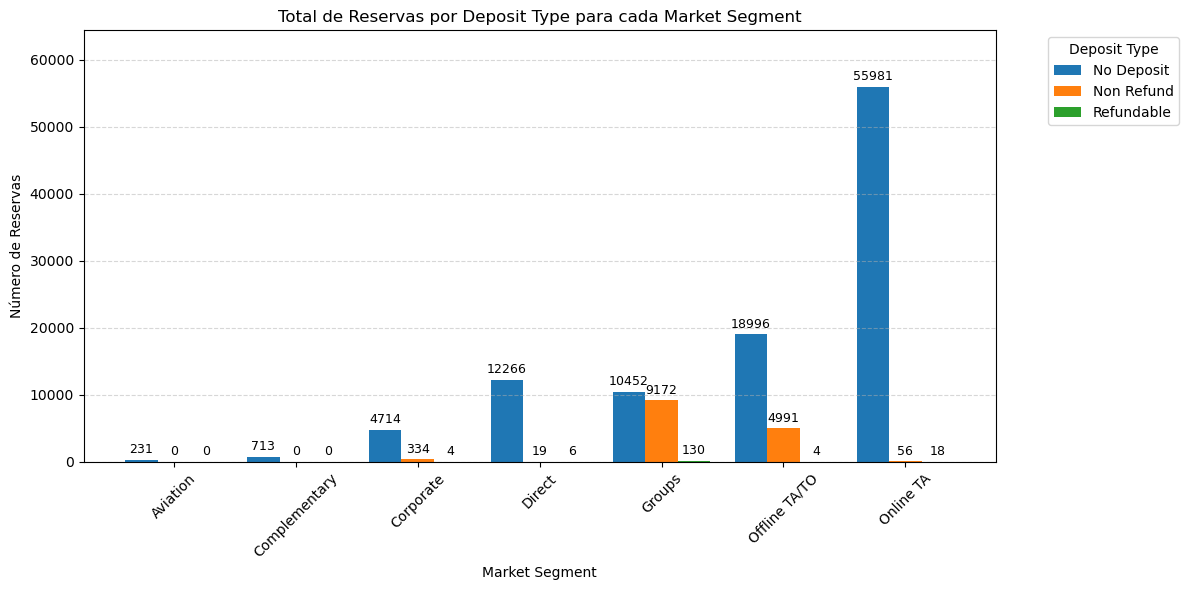

In [103]:


# 2. Conteo de reservas por market_segment y deposit_type
counts = (
    df
    .groupby(['market_segment', 'deposit_type'], observed=False)
    .size()
    .unstack(fill_value=0)
)
# Reset para usar en Matplotlib
counts = counts.reset_index()
deposit_types = counts.columns.drop('market_segment')

# 3. Configuración de posiciones
x = np.arange(len(counts))      # posiciones para cada market_segment
width = 0.8 / len(deposit_types)  # ancho de barra según número de deposit_type

fig, ax = plt.subplots(figsize=(12, 6))

# 4. Dibujar barras para cada deposit_type
for i, dtype in enumerate(deposit_types):
    ax.bar(
        x + i*width - (width*(len(deposit_types)-1)/2),
        counts[dtype],
        width,
        label=dtype
    )

# 5. Anotar valores encima de cada barra
max_height = counts[deposit_types].values.max()
for i, row in counts.iterrows():
    for j, dtype in enumerate(deposit_types):
        height = row[dtype]
        ax.text(
            x[i] + j*width - (width*(len(deposit_types)-1)/2),
            height + max_height*0.01,
            f"{int(height)}",
            ha='center',
            va='bottom',
            fontsize=9
        )

# 6. Etiquetas y estilo
ax.set_xlabel('Market Segment')
ax.set_ylabel('Número de Reservas')
ax.set_title('Total de Reservas por Deposit Type para cada Market Segment')
ax.set_xticks(x)
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.legend(title='Deposit Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Reservas canceladas vs No canceladas por tipo de cliente

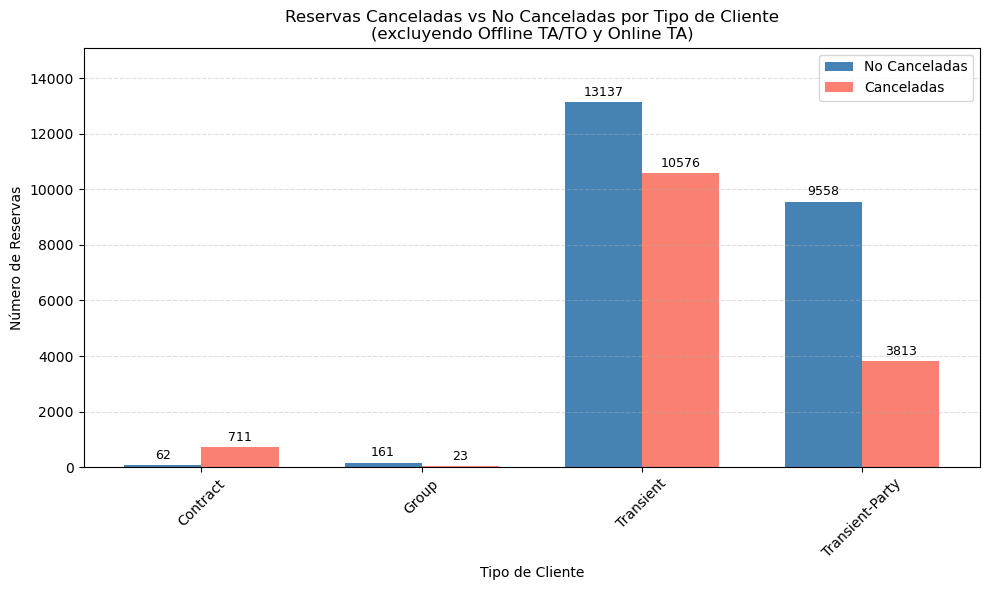

In [104]:
# 2. Filtrar excluyendo Offline TA/TO y Online TA
exclude_segments = ['Offline TA/TO', 'Online TA']
df_f = df[~df['market_segment'].isin(exclude_segments)].copy()

# 3. Agrupar por customer_type y estado de cancelación
counts = (
    df_f
    .groupby(['customer_type', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'No Canceladas', 1: 'Canceladas'})
    .reset_index()
)

# 4. Configurar posiciones
n_types = len(counts)
x = np.arange(n_types)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# 5. Dibujar barras side-by-side
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 6. Anotar valores encima de cada barra
max_h = counts[['No Canceladas','Canceladas']].values.max()
for bar in list(bars_no) + list(bars_yes):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max_h * 0.01,
        f"{int(h)}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# 7. Etiquetas y estilo
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas Canceladas vs No Canceladas por Tipo de Cliente\n(excluyendo Offline TA/TO y Online TA)')
ax.set_xticks(x)
ax.set_xticklabels(counts['customer_type'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, max_h * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


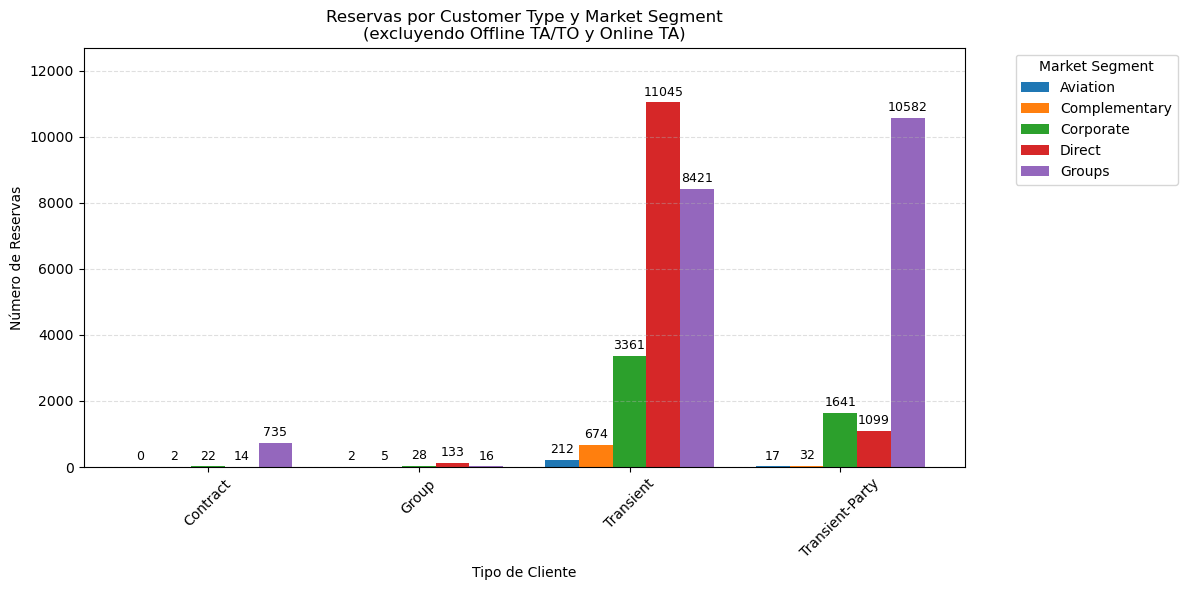

In [105]:
# 2. Filtrar excluyendo Offline TA/TO y Online TA
exclude_segments = ['Offline TA/TO', 'Online TA']
df_f = df[~df['market_segment'].isin(exclude_segments)].copy()

# 3. Contar reservas por customer_type y market_segment
counts = (
    df_f
    .groupby(['customer_type', 'market_segment'], observed=False)
    .size()
    .unstack(fill_value=0)
)

# 4. Preparar los índices y offsets
customer_types   = counts.index.tolist()
market_segments  = counts.columns.tolist()
n_types          = len(customer_types)
n_segments       = len(market_segments)
x                = np.arange(n_types)
width            = 0.8 / n_segments  # 80% del espacio dividido en n_segments barras

# 5. Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 6))

for j, ms in enumerate(market_segments):
    ax.bar(
        x + (j - (n_segments-1)/2) * width,
        counts[ms],
        width,
        label=ms
    )

# 6. Anotar valores encima de cada barra
max_height = counts.values.max()
for i, ct in enumerate(customer_types):
    for j, ms in enumerate(market_segments):
        val = counts.loc[ct, ms]
        xpos = x[i] + (j - (n_segments-1)/2) * width
        ax.text(
            xpos,
            val + max_height * 0.01,
            f"{int(val)}",
            ha='center', va='bottom',
            fontsize=9
        )

# 7. Etiquetas y estilo
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas por Customer Type y Market Segment\n(excluyendo Offline TA/TO y Online TA)')
ax.set_xticks(x)
ax.set_xticklabels(customer_types, rotation=45)
ax.legend(title='Market Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


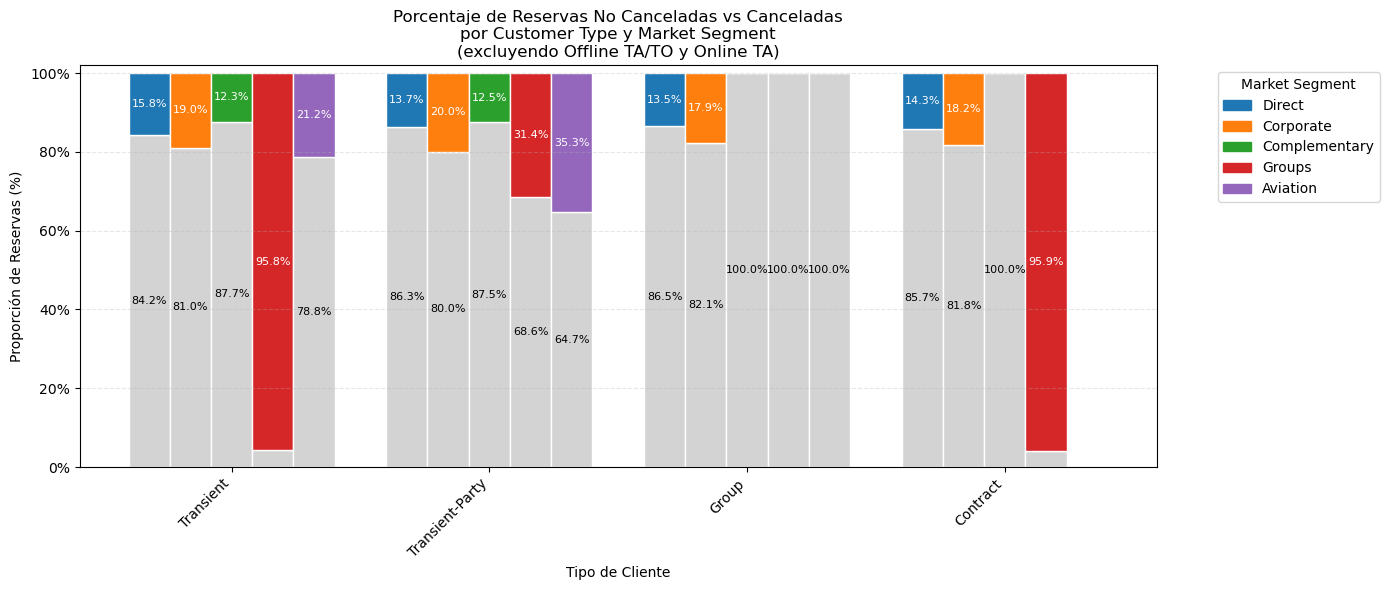

In [106]:
exclude = ['Offline TA/TO', 'Online TA']
df = df[~df['market_segment'].isin(exclude)].copy()

# 2. Agregar conteos
grp = (
    df
    .groupby(['customer_type','market_segment','is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0:'not_canceled',1:'canceled'})
)

# 3. Calcular proporciones
grp['total'] = grp['not_canceled'] + grp['canceled']
grp['p_not'] = grp['not_canceled'] / grp['total']
grp['p_yes'] = grp['canceled']     / grp['total']
grp = grp.reset_index()

# 4. Listas ordenadas
customer_types  = df['customer_type'].drop_duplicates().tolist()
market_segments = df['market_segment'].drop_duplicates().tolist()
n_ct = len(customer_types)
n_ms = len(market_segments)

# 5. Eje X
x = np.arange(n_ct)
total_w = 0.8
w_ms    = total_w / n_ms

# 6. Colores por segmento
palette = plt.get_cmap('tab10')
colors = {ms: palette(i) for i, ms in enumerate(market_segments)}

fig, ax = plt.subplots(figsize=(14,6))

# 7. Dibujar apiladas
for j, ms in enumerate(market_segments):
    # offset dentro de cada grupo de cliente
    offset = (j - (n_ms-1)/2) * w_ms
    xpos = x + offset

    p_not = []
    p_yes = []
    for ct in customer_types:
        row = grp[(grp['customer_type']==ct) & (grp['market_segment']==ms)]
        if not row.empty:
            p_not.append(row['p_not'].iloc[0])
            p_yes.append(row['p_yes'].iloc[0])
        else:
            p_not.append(0)
            p_yes.append(0)

    # barras apiladas
    ax.bar(xpos, p_not, w_ms, color='lightgray', edgecolor='white')
    ax.bar(xpos, p_yes, w_ms, bottom=p_not, color=colors[ms], edgecolor='white')

    # etiquetas de % si >5%
    for i in range(n_ct):
        if p_not[i] > 0.05:
            ax.text(xpos[i], p_not[i]/2,
                    f"{p_not[i]*100:.1f}%",
                    ha='center', va='center', fontsize=8)
        if p_yes[i] > 0.05:
            ax.text(xpos[i], p_not[i] + p_yes[i]/2,
                    f"{p_yes[i]*100:.1f}%",
                    ha='center', va='center', fontsize=8, color='white')

# 8. Ejes y leyenda
ax.set_xticks(x)
ax.set_xticklabels(customer_types, rotation=45, ha='right')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Proporción de Reservas (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0,1.02)
ax.set_title('Porcentaje de Reservas No Canceladas vs Canceladas\n'
             'por Customer Type y Market Segment\n(excluyendo Offline TA/TO y Online TA)')

# leyenda de segmentos
handles = [plt.matplotlib.patches.Patch(color=colors[ms], label=ms) 
           for ms in market_segments]
ax.legend(handles=handles, title='Market Segment', bbox_to_anchor=(1.05,1), loc='upper left')

ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

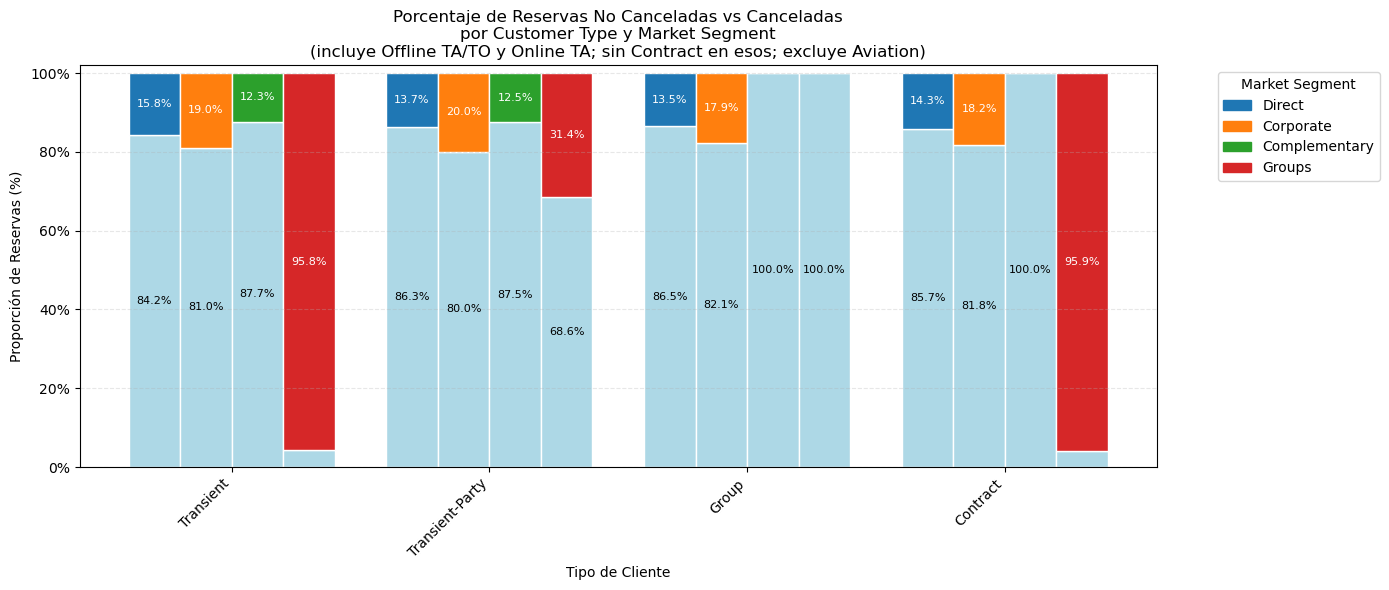

In [107]:
# Filtrar:
#    - Excluir Aviation por completo
#    - Incluir Offline TA/TO y Online TA
#    - Pero para esos dos segmentos, excluir las reservas con customer_type "Contract"
df_f = df[df['market_segment'] != 'Aviation'].copy()
mask_exclude_contract = (
    df_f['market_segment'].isin(['Offline TA/TO', 'Online TA']) &
    (df_f['customer_type'] == 'Contract')
)
df_f = df_f[~mask_exclude_contract]

# 3. Agrupar para contar canceladas y no canceladas
grp = (
    df_f
      .groupby(['customer_type','market_segment','is_canceled'], observed=False)
      .size()
      .unstack(fill_value=0)
      .rename(columns={0:'not_canceled', 1:'canceled'})
)

# 4. Calcular proporciones
grp['total'] = grp['not_canceled'] + grp['canceled']
grp['p_not'] = grp['not_canceled'] / grp['total']
grp['p_yes'] = grp['canceled']     / grp['total']
grp = grp.reset_index()

# 5. Listas ordenadas de categorías
customer_types  = df_f['customer_type'].drop_duplicates().tolist()
market_segments = df_f['market_segment'].drop_duplicates().tolist()
n_ct = len(customer_types)
n_ms = len(market_segments)

# 6. Posiciones y ancho
x = np.arange(n_ct)
total_width = 0.8
w_ms = total_width / n_ms

# 7. Definir colores para cada market_segment
palette = plt.get_cmap('tab10')
colors = {ms: palette(i) for i, ms in enumerate(market_segments)}

fig, ax = plt.subplots(figsize=(14,6))

# 8. Dibujar barras apiladas
for j, ms in enumerate(market_segments):
    offset = (j - (n_ms-1)/2) * w_ms
    xpos = x + offset

    p_not = []
    p_yes = []
    for ct in customer_types:
        row = grp[(grp['customer_type']==ct) & (grp['market_segment']==ms)]
        if not row.empty:
            p_not.append(row['p_not'].iloc[0])
            p_yes.append(row['p_yes'].iloc[0])
        else:
            p_not.append(0)
            p_yes.append(0)

    ax.bar(xpos, p_not, w_ms, color='lightblue', edgecolor='white')
    ax.bar(xpos, p_yes, w_ms, bottom=p_not, color=colors[ms], edgecolor='white')

    # Etiquetas de porcentaje si >5%
    for i in range(n_ct):
        if p_not[i] > 0.05:
            ax.text(xpos[i], p_not[i]/2,
                    f"{p_not[i]*100:.1f}%", ha='center', va='center', fontsize=8)
        if p_yes[i] > 0.05:
            ax.text(xpos[i], p_not[i] + p_yes[i]/2,
                    f"{p_yes[i]*100:.1f}%", ha='center', va='center', fontsize=8, color='white')

# 9. Configuración final
ax.set_xticks(x)
ax.set_xticklabels(customer_types, rotation=45, ha='right')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Proporción de Reservas (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0,1.02)
ax.set_title(
    'Porcentaje de Reservas No Canceladas vs Canceladas\n'
    'por Customer Type y Market Segment\n'
    '(incluye Offline TA/TO y Online TA; sin Contract en esos; excluye Aviation)'
)

# Leyenda de market segments
handles = [plt.matplotlib.patches.Patch(color=colors[ms], label=ms) 
           for ms in market_segments]
ax.legend(handles=handles, title='Market Segment', bbox_to_anchor=(1.05,1), loc='upper left')

ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#################################################################################################################################

# 1. Filtrar como especificaste
df_f = df[df['market_segment'] != 'Aviation'].copy()
mask_exclude_contract = (
    df_f['market_segment'].isin(['Offline TA/TO', 'Online TA']) &
    (df_f['customer_type'] == 'Contract')
)
df_f = df_f[~mask_exclude_contract]

# 2. Agrupamiento y proporciones
grp = (
    df_f
    .groupby(['customer_type', 'market_segment', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'not_canceled', 1: 'canceled'})
    .reset_index()
)
grp['total'] = grp['not_canceled'] + grp['canceled']
grp['p_not'] = grp['not_canceled'] / grp['total']
grp['p_yes'] = grp['canceled'] / grp['total']

# 3. Ejes
customer_types = sorted(df_f['customer_type'].unique())
market_segments = sorted(df_f['market_segment'].unique())
n_ct = len(customer_types)
n_ms = len(market_segments)

x_base = np.arange(n_ct)
total_width = 0.8
w_ms = total_width / n_ms

# 4. Colores
import matplotlib.pyplot as plt
palette = plt.get_cmap('tab10')
colors = {ms: f'rgba{tuple(int(c*255) for c in palette(i)[:3]) + (1,)}' for i, ms in enumerate(market_segments)}

# 5. Crear figura
fig = go.Figure()

for j, ms in enumerate(market_segments):
    offset = (j - (n_ms - 1) / 2) * w_ms
    xpos = x_base + offset

    p_not, p_yes = [], []
    for ct in customer_types:
        row = grp[(grp['customer_type'] == ct) & (grp['market_segment'] == ms)]
        if not row.empty:
            p_not.append(row['p_not'].iloc[0])
            p_yes.append(row['p_yes'].iloc[0])
        else:
            p_not.append(0)
            p_yes.append(0)

    # Barr

In [108]:
# Azahara

In [109]:
# Ensuring arrival_date is imported as datetime type
df = pd.read_csv('hotel_bookings_clean.csv', parse_dates=['arrival_date'])

 # Relación entre Lead Time y Cancelaciones

## Análisis de la distribución del Lead time (histograma)

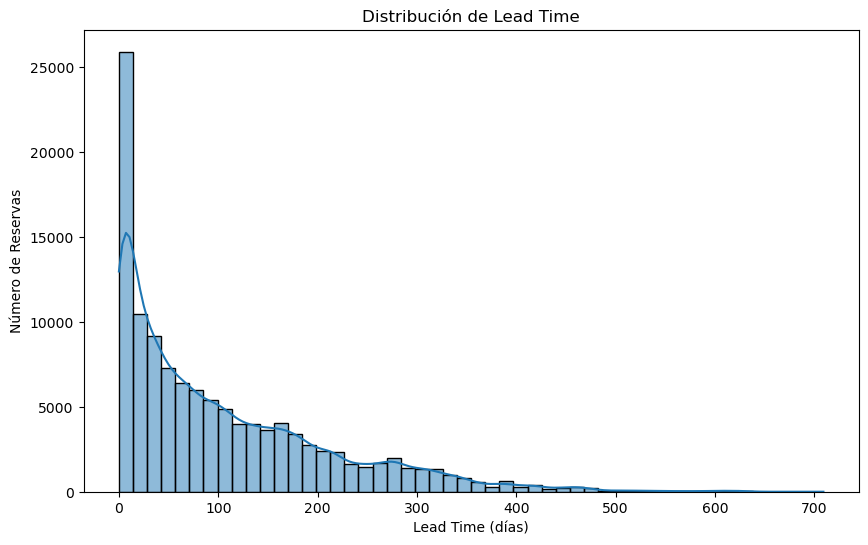

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de lead_time
plt.figure(figsize=(10,6))
sns.histplot(df['lead_time'], bins=50, kde=True)
plt.title('Distribución de Lead Time')
plt.xlabel('Lead Time (días)')
plt.ylabel('Número de Reservas')
plt.show()


#### Como se puede apreciar, cuanto más cerca es el día del check-in del día de la reserva (reservas de última hora o insitu), mayor es el número de reservas y al revés, cuato mayor es el Lead Time, menor es el número de reservas

## Análisis de la Tasa de Cancelación según el Lead time

In [111]:
# Definir los rangos
bins = [0, 7, 30, 90, df['lead_time'].max()]
labels = ['0-7 días', '8-30 días', '31-90 días', '>90 días']

# Crear nueva columna categórica
df['lead_time_group'] = pd.cut(df['lead_time'], bins=bins, labels=labels)

# Agrupar por lead_time_group
cancelaciones_por_grupo = df.groupby('lead_time_group', observed=False)['is_canceled'].mean() * 100


print(cancelaciones_por_grupo)





lead_time_group
0-7 días      11.118779
8-30 días     28.055600
31-90 días    37.848226
>90 días      50.735698
Name: is_canceled, dtype: float64


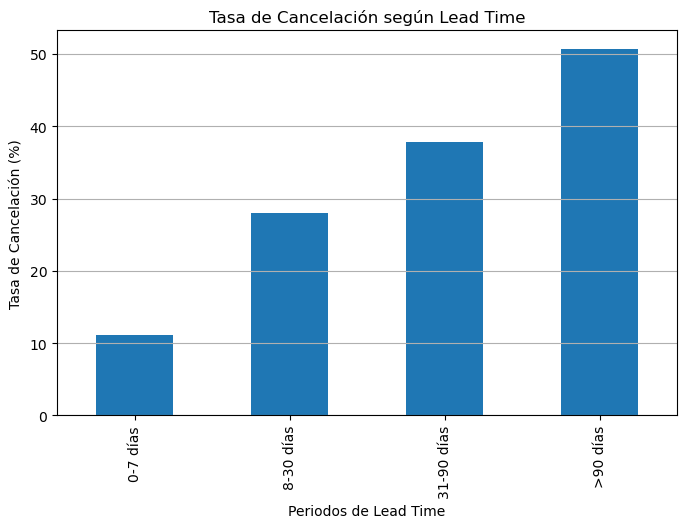

In [112]:
# Gráfico de barras
plt.figure(figsize=(8,5))
cancelaciones_por_grupo.plot(kind='bar')
plt.title('Tasa de Cancelación según Lead Time')
plt.xlabel('Periodos de Lead Time')
plt.ylabel('Tasa de Cancelación (%)')
plt.grid(axis='y')
plt.show()

#### A mayor número de días en los periodos del Lead Time, mayor es la Tasa de cancelacion. Por tanto vamos a analizar si existe correlación entre el lead time y la cancelacion (is_canceled)

# Planteamiento de Hipótesis

##### H0= No hay correlación entre Lead Time y la cancelacion de la reserva (is_canceled)
##### H1= Hay correlación entre Lead Time y la cancelacion de la reserva (is_canceled)

##### Tal y como se aprecia en las gráficas, las variables no siguen una distribucion normal, por tanto para analizar la correlacion entre las variables emplearé la correlacion de Spearman, debido a que una de las variables es binaria

### Correlacion de Spearman

In [113]:
spearman_corr, p_value = spearmanr(df['lead_time'], df['is_canceled'])

print(f"Correlación de Spearman: {spearman_corr:.4f}")
print(f"P-valor: {p_value:.4f}")



Correlación de Spearman: 0.3130
P-valor: 0.0000


###### ✅ La relacion es positiva y moderada
###### ✅ Esto indica que a mayor lead time, hay más probabilidad de cancelación.
###### ✅  Spearman (0.32):  sugiere que la relación podría no ser perfectamente lineal, pero sí monótona: cuanto más anticipada la reserva, más probable es la cancelación.

### Regresión Logística

##### H0= No hay relación entre Lead Time y la cancelacion de la reserva (is_canceled)
##### H1= Hay relación entre Lead Time y la cancelacion de la reserva (is_canceled)

Optimization terminated successfully.
         Current function value: 0.618732
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               118087
Model:                          Logit   Df Residuals:                   118085
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 May 2025   Pseudo R-squ.:                 0.06370
Time:                        15:20:50   Log-Likelihood:                -73064.
converged:                       True   LL-Null:                       -78035.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1482      0.009   -124.430      0.000      -1.166      -1.130
lead_time      0.0058   6.15e

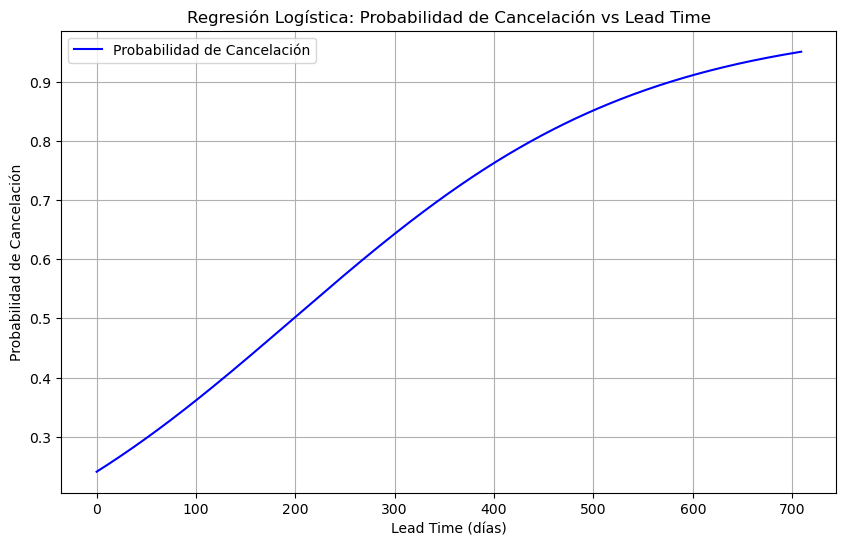

In [114]:
# Variables
X = df['lead_time']
y = df['is_canceled']

# Añadir constante (intercepto)
X_const = sm.add_constant(X)

# Modelo de regresión logística
model = sm.Logit(y, X_const)
result = model.fit()

# Mostrar resumen del modelo
print(result.summary())

# Predecir probabilidades en un rango de lead_time
lead_range = np.linspace(0, X.max(), 500)
X_pred = sm.add_constant(lead_range)
y_pred_prob = result.predict(X_pred)

# Gráfico de la curva logística
plt.figure(figsize=(10, 6))
plt.plot(lead_range, y_pred_prob, label='Probabilidad de Cancelación', color='blue')
plt.xlabel('Lead Time (días)')
plt.ylabel('Probabilidad de Cancelación')
plt.title('Regresión Logística: Probabilidad de Cancelación vs Lead Time')
plt.grid(True)
plt.legend()
plt.show()

###### Como se puede apreciar, el gráfico visualiza claramente cómo la probabilidad de cancelación aumenta con el lead time, lo que refuerza lo que mostró la correlación de Spearman.

## Conclusión

##### Por tanto, se puede concluir que existe una correlación positiva entre el tiempo de anticipación de la reserva y la probabilidad de cancelarla

In [115]:
#David

In [116]:
# Ensuring arrival_date is imported as datetime type
df = pd.read_csv('hotel_bookings_clean.csv', parse_dates=['arrival_date'])

# Studying ADR vs ("is_cancelled" , "arrival_date-month", "market_segment", "distribution_channel", "deposit_type", "customer_type")


Overall Average Daily Rate: $103.65

=== ADR by is_canceled ===
True:
  Average ADR: $105.39 (1.68% from overall)
  Median ADR: $97.00
  Range: $0.50 to $450.00
  Count: 44114.0 bookings
False:
  Average ADR: $102.61 (-1.0% from overall)
  Median ADR: $95.00
  Range: $0.26 to $510.00
  Count: 73973.0 bookings

=== ADR by market_segment ===
Direct:
  Average ADR: $118.11 (13.95% from overall)
  Median ADR: $107.00
  Range: $2.00 to $451.50
  Count: 12291.0 bookings
Online TA:
  Average ADR: $118.03 (13.87% from overall)
  Median ADR: $110.00
  Range: $0.50 to $450.00
  Count: 56055.0 bookings
Aviation:
  Average ADR: $102.74 (-0.88% from overall)
  Median ADR: $95.00
  Range: $79.00 to $193.50
  Count: 231.0 bookings
Complementary:
  Average ADR: $96.62 (-6.78% from overall)
  Median ADR: $102.69
  Range: $1.00 to $170.00
  Count: 713.0 bookings
Offline TA/TO:
  Average ADR: $88.52 (-14.6% from overall)
  Median ADR: $87.00
  Range: $1.00 to $510.00
  Count: 23991.0 bookings
Groups:
  A

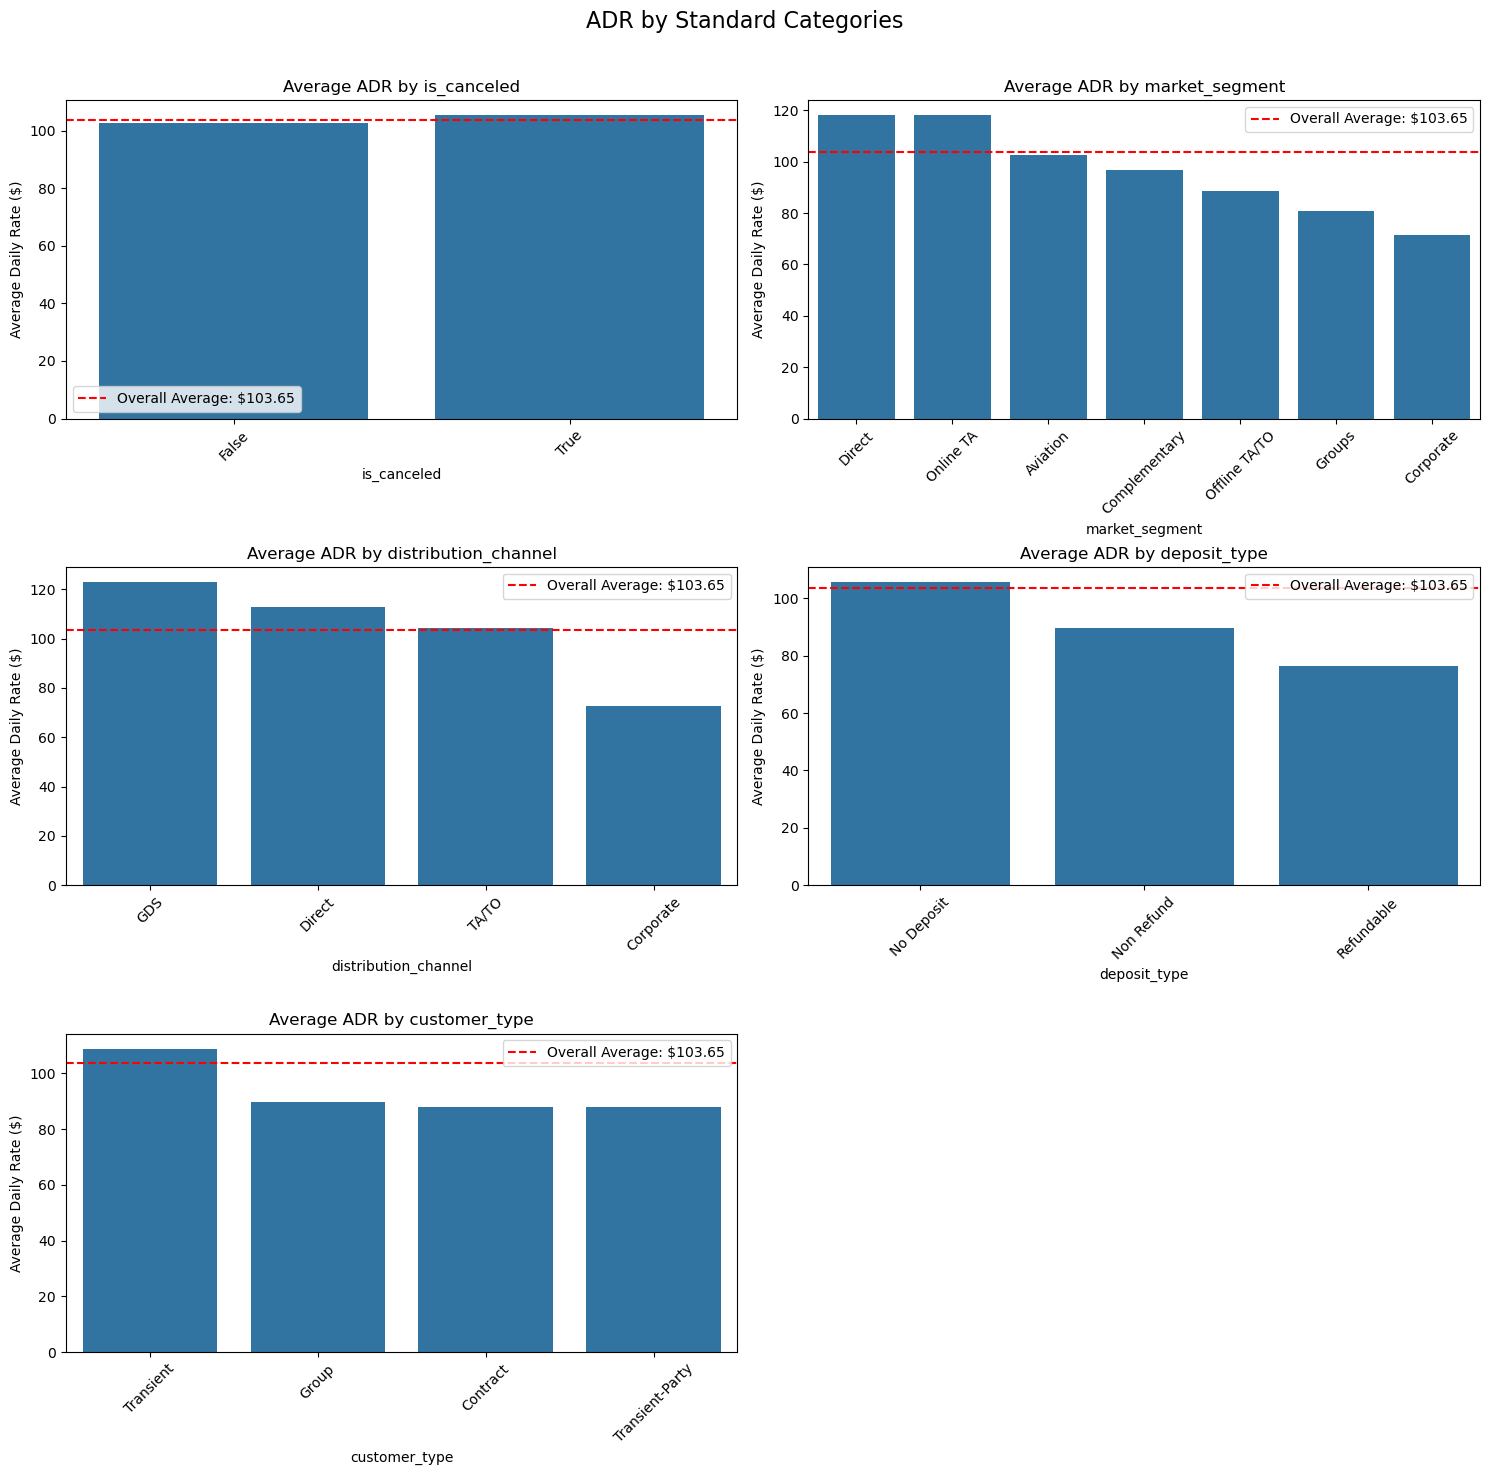


=== ADR by month ===
January:
  Average ADR: $72.57 (-29.99% from overall)
  Median ADR: $72.00
  Range: $1.00 to $284.20
  Count: 5816.0 bookings
February:
  Average ADR: $75.44 (-27.21% from overall)
  Median ADR: $75.00
  Range: $0.50 to $284.20
  Count: 7944.0 bookings
March:
  Average ADR: $81.81 (-21.07% from overall)
  Median ADR: $80.00
  Range: $0.26 to $285.00
  Count: 9661.0 bookings
April:
  Average ADR: $101.81 (-1.78% from overall)
  Median ADR: $98.00
  Range: $3.00 to $336.00
  Count: 11005.0 bookings
May:
  Average ADR: $110.37 (6.48% from overall)
  Median ADR: $108.00
  Range: $2.00 to $510.00
  Count: 11692.0 bookings
June:
  Average ADR: $117.91 (13.76% from overall)
  Median ADR: $115.00
  Range: $4.00 to $333.67
  Count: 10879.0 bookings
July:
  Average ADR: $128.36 (23.84% from overall)
  Median ADR: $118.80
  Range: $1.80 to $508.00
  Count: 12553.0 bookings
August:
  Average ADR: $141.54 (36.56% from overall)
  Median ADR: $130.50
  Range: $1.56 to $450.00
  

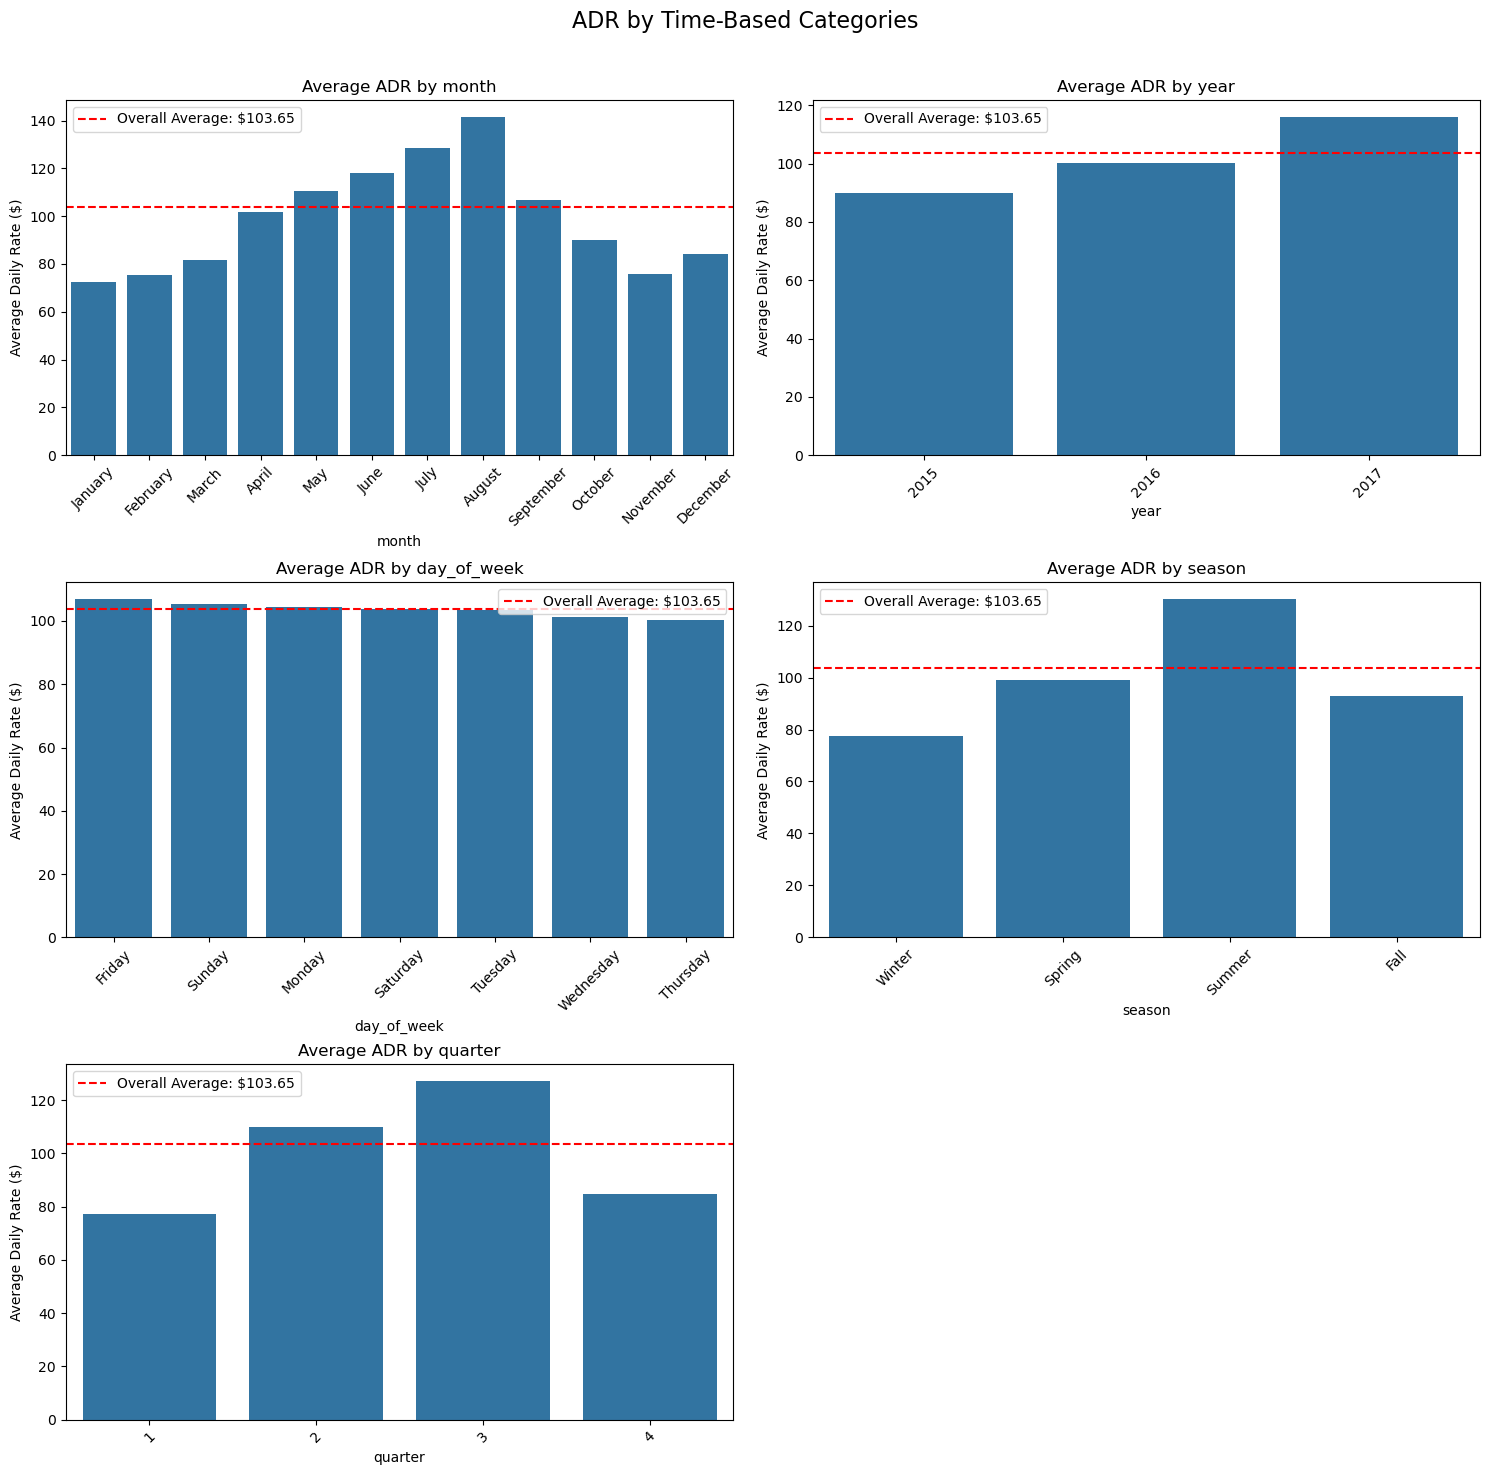

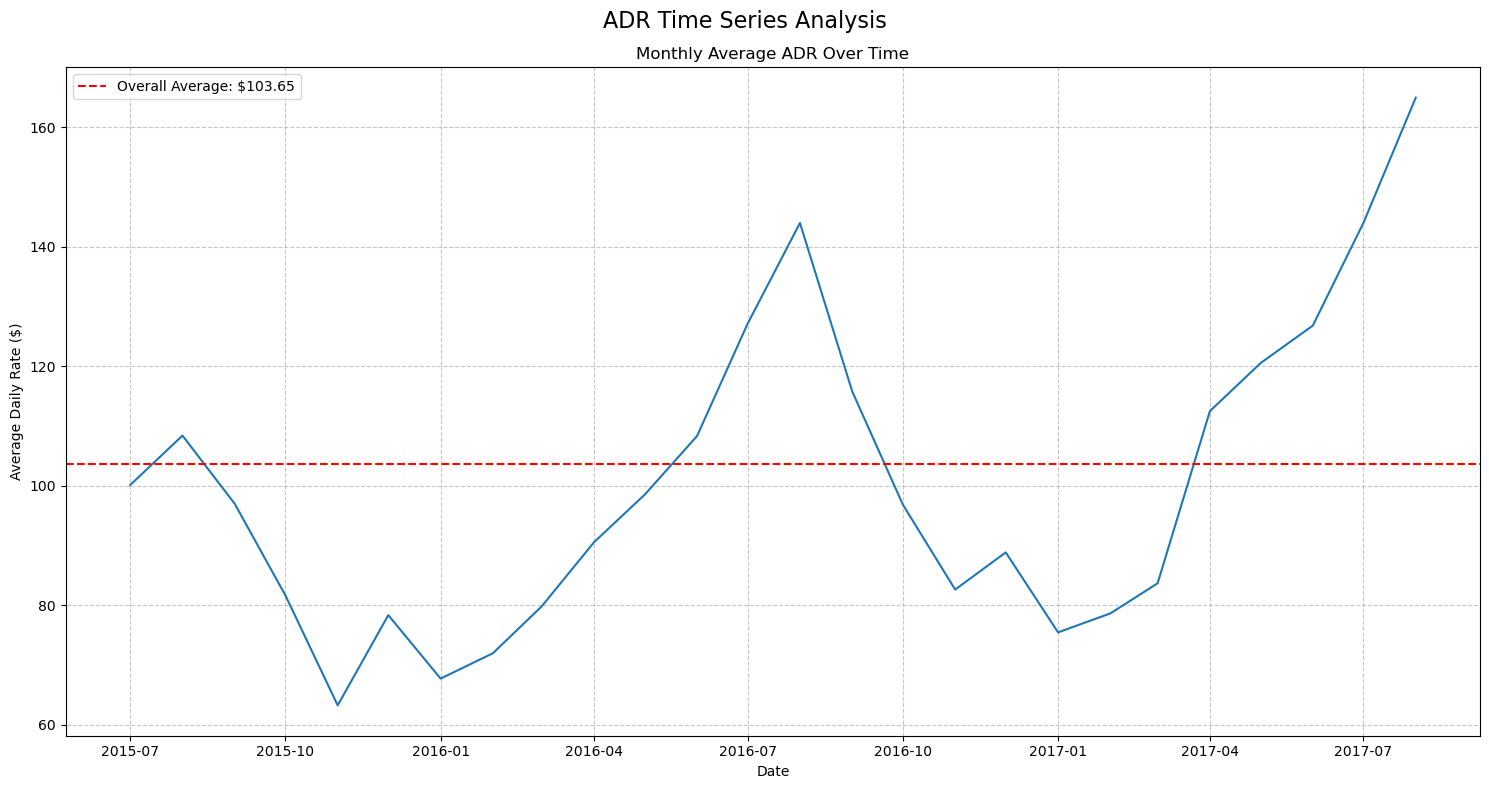


=== Statistical Significance (ANOVA) ===
is_canceled:
  F-statistic: 99.24
  p-value: 0.0000000000
  Result: Statistically significant difference in ADR between categories
market_segment:
  F-statistic: 3171.77
  p-value: 0.0000000000
  Result: Statistically significant difference in ADR between categories
distribution_channel:
  F-statistic: 1195.45
  p-value: 0.0000000000
  Result: Statistically significant difference in ADR between categories
deposit_type:
  F-statistic: 802.64
  p-value: 0.0000000000
  Result: Statistically significant difference in ADR between categories
customer_type:
  F-statistic: 1563.17
  p-value: 0.0000000000
  Result: Statistically significant difference in ADR between categories
month:
  F-statistic: 3063.51
  p-value: 0.0000000000
  Result: Statistically significant difference in ADR between categories
year:
  F-statistic: 2653.78
  p-value: 0.0000000000
  Result: Statistically significant difference in ADR between categories
day_of_week:
  F-statistic: 

In [117]:
# Calculate the overall average for the ADR column
overall_adr_avg = df['adr'].mean()
print(f"Overall Average Daily Rate: ${overall_adr_avg:.2f}")

# Extract various date components for analysis
df['month'] = df['arrival_date'].dt.month_name()
df['year'] = df['arrival_date'].dt.year
df['day_of_week'] = df['arrival_date'].dt.day_name()
df['quarter'] = df['arrival_date'].dt.quarter

# Define seasons based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['arrival_date'].dt.month.apply(get_season)

# Create a function to compare ADR with a categorical column
def compare_adr_with_column(column_name):
    print(f"\n=== ADR by {column_name} ===")
    
    # Group by the column and calculate statistics for ADR
    grouped = df.groupby(column_name)['adr'].agg(['mean', 'median', 'count', 'min', 'max'])
    
    # Sort by categories for time-based columns to maintain chronological order
    if column_name in ['month', 'year', 'quarter', 'season']:
        if column_name == 'month':
            # Sort months chronologically
            month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                           'July', 'August', 'September', 'October', 'November', 'December']
            grouped = grouped.reindex(month_order)
        elif column_name == 'season':
            # Sort seasons chronologically
            season_order = ['Winter', 'Spring', 'Summer', 'Fall']
            grouped = grouped.reindex(season_order)
        elif column_name == 'day_of_week':
            # Sort days of week chronologically
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            grouped = grouped.reindex(day_order)
        else:
            # For year and quarter, sort numerically
            grouped = grouped.sort_index()
    else:
        # For non-time columns, sort by mean ADR
        grouped = grouped.sort_values('mean', ascending=False)
    
    # Calculate percentage difference from overall average
    grouped['diff_from_avg'] = ((grouped['mean'] - overall_adr_avg) / overall_adr_avg * 100).round(2)
    
    # Format the statistics
    for category, stats in grouped.iterrows():
        print(f"{category}:")
        print(f"  Average ADR: ${stats['mean']:.2f} ({stats['diff_from_avg']}% from overall)")
        print(f"  Median ADR: ${stats['median']:.2f}")
        print(f"  Range: ${stats['min']:.2f} to ${stats['max']:.2f}")
        print(f"  Count: {stats['count']} bookings")
    
    return grouped

# Compare ADR with standard categories
standard_columns = [
    'is_canceled',
    'market_segment', 
    'distribution_channel', 
    'deposit_type', 
    'customer_type'
]

# Time-based columns for comparison
time_columns = [
    'month',
    'year',
    'day_of_week',
    'season',
    'quarter'
]

# Create visualizations for standard categories
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 15))
plt.suptitle('ADR by Standard Categories', fontsize=16)

for i, column in enumerate(standard_columns):
    # Create subplot
    plt.subplot(3, 2, i+1)
    
    # Get the data
    grouped_data = compare_adr_with_column(column)
    
    # Create bar plot
    sns.barplot(x=grouped_data.index, y=grouped_data['mean'])
    plt.title(f'Average ADR by {column}')
    plt.xlabel(column)
    plt.ylabel('Average Daily Rate ($)')
    plt.xticks(rotation=45)
    
    # Add horizontal line for overall average
    plt.axhline(y=overall_adr_avg, color='r', linestyle='--', label=f'Overall Average: ${overall_adr_avg:.2f}')
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Create visualizations for time-based categories
plt.figure(figsize=(15, 15))
plt.suptitle('ADR by Time-Based Categories', fontsize=16)

for i, column in enumerate(time_columns):
    # Create subplot
    plt.subplot(3, 2, i+1)
    
    # Get the data
    grouped_data = compare_adr_with_column(column)
    
    # Create bar plot
    sns.barplot(x=grouped_data.index, y=grouped_data['mean'])
    plt.title(f'Average ADR by {column}')
    plt.xlabel(column)
    plt.ylabel('Average Daily Rate ($)')
    plt.xticks(rotation=45)
    
    # Add horizontal line for overall average
    plt.axhline(y=overall_adr_avg, color='r', linestyle='--', label=f'Overall Average: ${overall_adr_avg:.2f}')
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Time series analysis of ADR trends
plt.figure(figsize=(15, 8))
plt.suptitle('ADR Time Series Analysis', fontsize=16)

# Monthly ADR time series - Fixed to avoid creating a duplicate column
# Group by year and month, then calculate average ADR
monthly_adr = df.groupby([df['year'], df['month']])['adr'].mean().reset_index()

# Create date strings for plotting
monthly_adr['month_num'] = monthly_adr['month'].map({
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
})
monthly_adr['date_str'] = monthly_adr['year'].astype(str) + '-' + monthly_adr['month_num'].astype(str).str.zfill(2)
monthly_adr['date'] = pd.to_datetime(monthly_adr['date_str'])
monthly_adr = monthly_adr.sort_values('date')

plt.plot(monthly_adr['date'], monthly_adr['adr'])
plt.title('Monthly Average ADR Over Time')
plt.xlabel('Date')
plt.ylabel('Average Daily Rate ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=overall_adr_avg, color='r', linestyle='--', label=f'Overall Average: ${overall_adr_avg:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Statistical analysis: ANOVA test for each categorical variable
from scipy.stats import f_oneway

print("\n=== Statistical Significance (ANOVA) ===")
for column in standard_columns + time_columns:
    # Get unique categories
    categories = df[column].unique()
    
    # Create groups of ADR values for each category
    groups = [df[df[column] == category]['adr'].dropna() for category in categories]
    
    # Perform ANOVA test
    f_stat, p_value = f_oneway(*groups)
    
    print(f"{column}:")
    print(f"  F-statistic: {f_stat:.2f}")
    print(f"  p-value: {p_value:.10f}")
    if p_value < 0.05:
        print("  Result: Statistically significant difference in ADR between categories")
    else:
        print("  Result: No statistically significant difference in ADR between categories")

## Comparing hotel type with ADR and cross comparing by seasons. 

=== ADR Analysis by Hotel Type and Season ===

1. Overall ADR by Hotel Type


,Average ADR,Number of Bookings,Standard Deviation
hotel,,,
City Hotel,$106.85,78878,$37.18
Resort Hotel,$97.21,39209,$60.37


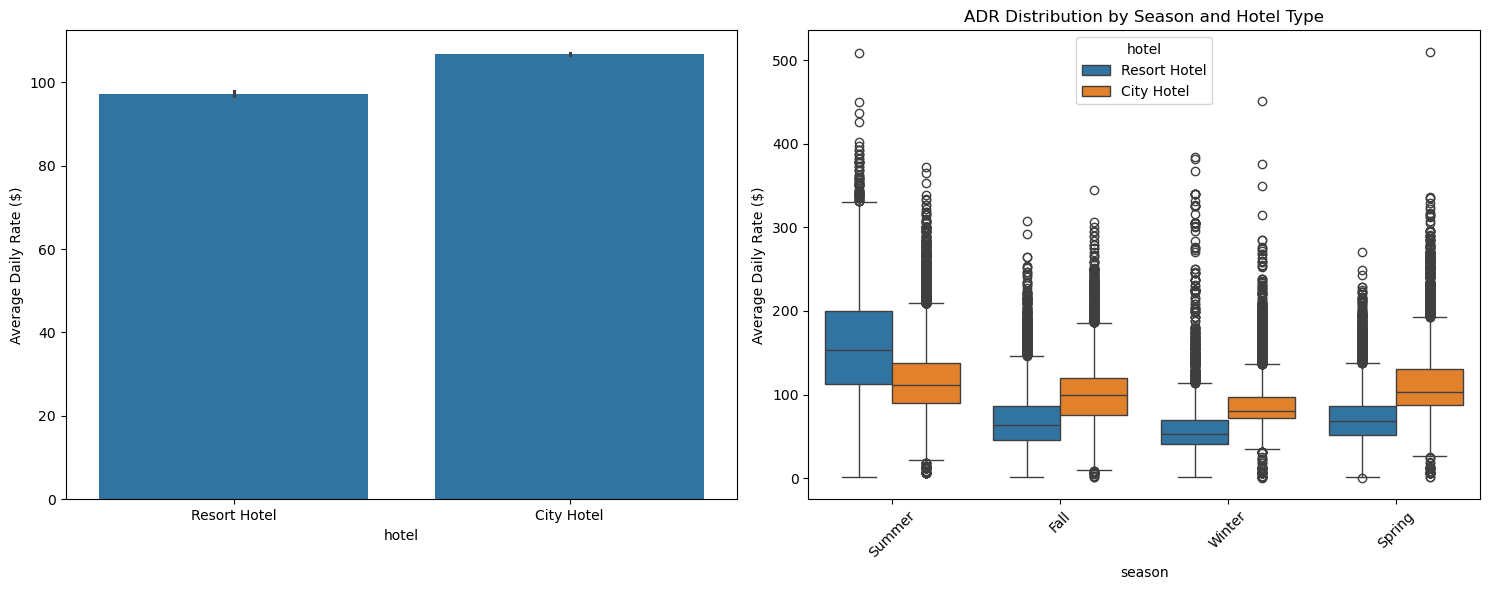


2. Seasonal ADR Analysis



3. Key Findings:

Resort Hotel:
• Highest ADR: Summer ($158.52)
• Lowest ADR: Winter ($60.63)
• Seasonal variation: 161.46%

City Hotel:
• Highest ADR: Summer ($116.13)
• Lowest ADR: Winter ($87.71)
• Seasonal variation: 32.4%


In [118]:
# Define seasons based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Add season column based on arrival_date
df['season'] = df['arrival_date'].dt.month.apply(get_season)

# Calculate overall statistics
print("=== ADR Analysis by Hotel Type and Season ===\n")

# 1. Overall ADR by Hotel Type
hotel_adr = df.groupby('hotel')['adr'].agg(['mean', 'count', 'std']).round(2)
hotel_adr.columns = ['Average ADR', 'Number of Bookings', 'Standard Deviation']

# 2. ADR by Hotel Type and Season
hotel_season_adr = df.pivot_table(
    values='adr',
    index='hotel',
    columns='season',
    aggfunc=['mean', 'count', 'std']
).round(2)

# Reshape and rename columns for better presentation
hotel_season_stats = pd.DataFrame()
for stat in ['mean', 'count', 'std']:
    stat_df = hotel_season_adr[stat]
    stat_df.columns = [f'{season} ({stat})' for season in stat_df.columns]
    hotel_season_stats = pd.concat([hotel_season_stats, stat_df], axis=1)

# Sort columns by season and statistic
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
col_order = []
for season in season_order:
    col_order.extend([f'{season} (mean)', f'{season} (count)', f'{season} (std)'])
hotel_season_stats = hotel_season_stats[col_order]

# Display styled tables
print("1. Overall ADR by Hotel Type")
styled_hotel_adr = hotel_adr.style\
    .set_properties(**{
        'background-color': '#000000',
        'color': '#ffffff',
        'border-color': '#333333',
        'border-style': 'solid',
        'border-width': '1px',
        'padding': '10px',
        'text-align': 'left'
    })\
    .set_table_styles([
        {'selector': 'th',
         'props': [('background-color', '#4CAF50'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('padding', '10px'),
                  ('text-align', 'left')]},
        {'selector': 'tr:hover',
         'props': [('background-color', '#1a1a1a')]}
    ])\
    .format({
        'Average ADR': '${:.2f}',
        'Standard Deviation': '${:.2f}'
    })

display(styled_hotel_adr)

# Create visualizations
plt.figure(figsize=(15, 6))

# 1. Bar plot of ADR by Hotel Type
plt.subplot(1, 2, 1)
sns.barplot(data=df, x='hotel', y='adr', errorbar=('ci', 95))
plt.ylabel('Average Daily Rate ($)')

# 2. Box plot of ADR by Hotel Type and Season
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='season', y='adr', hue='hotel')
plt.title('ADR Distribution by Season and Hotel Type')
plt.ylabel('Average Daily Rate ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate and display seasonal trends
print("\n2. Seasonal ADR Analysis")
seasonal_analysis = df.pivot_table(
    values='adr',
    index='season',
    columns='hotel',
    aggfunc=['mean', 'count', 'std']
).round(2)

styled_seasonal = seasonal_analysis.style\
    .set_properties(**{
        'background-color': '#000000',
        'color': '#ffffff',
        'border-color': '#333333',
        'border-style': 'solid',
        'border-width': '1px',
        'padding': '10px',
        'text-align': 'left'
    })\
    .set_table_styles([
        {'selector': 'th',
         'props': [('background-color', '#4CAF50'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('padding', '10px'),
                  ('text-align', 'left')]},
        {'selector': 'tr:hover',
         'props': [('background-color', '#1a1a1a')]}
    ])

display(styled_seasonal)

# Calculate and display percentage differences
print("\n3. Key Findings:")
for hotel_type in df['hotel'].unique():
    max_season = df[df['hotel'] == hotel_type].groupby('season')['adr'].mean().idxmax()
    min_season = df[df['hotel'] == hotel_type].groupby('season')['adr'].mean().idxmin()
    max_adr = df[(df['hotel'] == hotel_type) & (df['season'] == max_season)]['adr'].mean()
    min_adr = df[(df['hotel'] == hotel_type) & (df['season'] == min_season)]['adr'].mean()
    diff_percent = ((max_adr - min_adr) / min_adr * 100).round(2)
    
    print(f"\n{hotel_type}:")
    print(f"• Highest ADR: {max_season} (${max_adr:.2f})")
    print(f"• Lowest ADR: {min_season} (${min_adr:.2f})")
    print(f"• Seasonal variation: {diff_percent}%")

## Summary for Most profitable segments and channels (adjusted ADR).

=== COMPREHENSIVE ADR ANALYSIS SUMMARY ===


--- IS_CANCELED ---
Lowest ADR: False ($102.61, -1.0% from average)
Highest ADR: True ($105.39, 1.68% from average)
ADR Range: $2.780000000000001
Most common: False (62.64% of bookings)
Recommendation: Analyze cancellation patterns to develop targeted pricing strategies

--- MARKET_SEGMENT ---
Lowest ADR: Corporate ($71.49, -31.03% from average)
Highest ADR: Direct ($118.11, 13.95% from average)
ADR Range: $46.620000000000005
Most common: Online TA (47.47% of bookings)
Recommendation: Target more bookings from Direct segment; review pricing strategy for Corporate segment

--- DISTRIBUTION_CHANNEL ---
Lowest ADR: Corporate ($72.59, -29.97% from average)
Highest ADR: GDS ($123.0, 18.67% from average)
ADR Range: $50.41
Most common: TA/TO (82.31% of bookings)
Recommendation: Focus marketing efforts on GDS channel; negotiate better rates or reduce dependency on Corporate

--- DEPOSIT_TYPE ---
Lowest ADR: Refundable ($76.21, -26.47% from average)


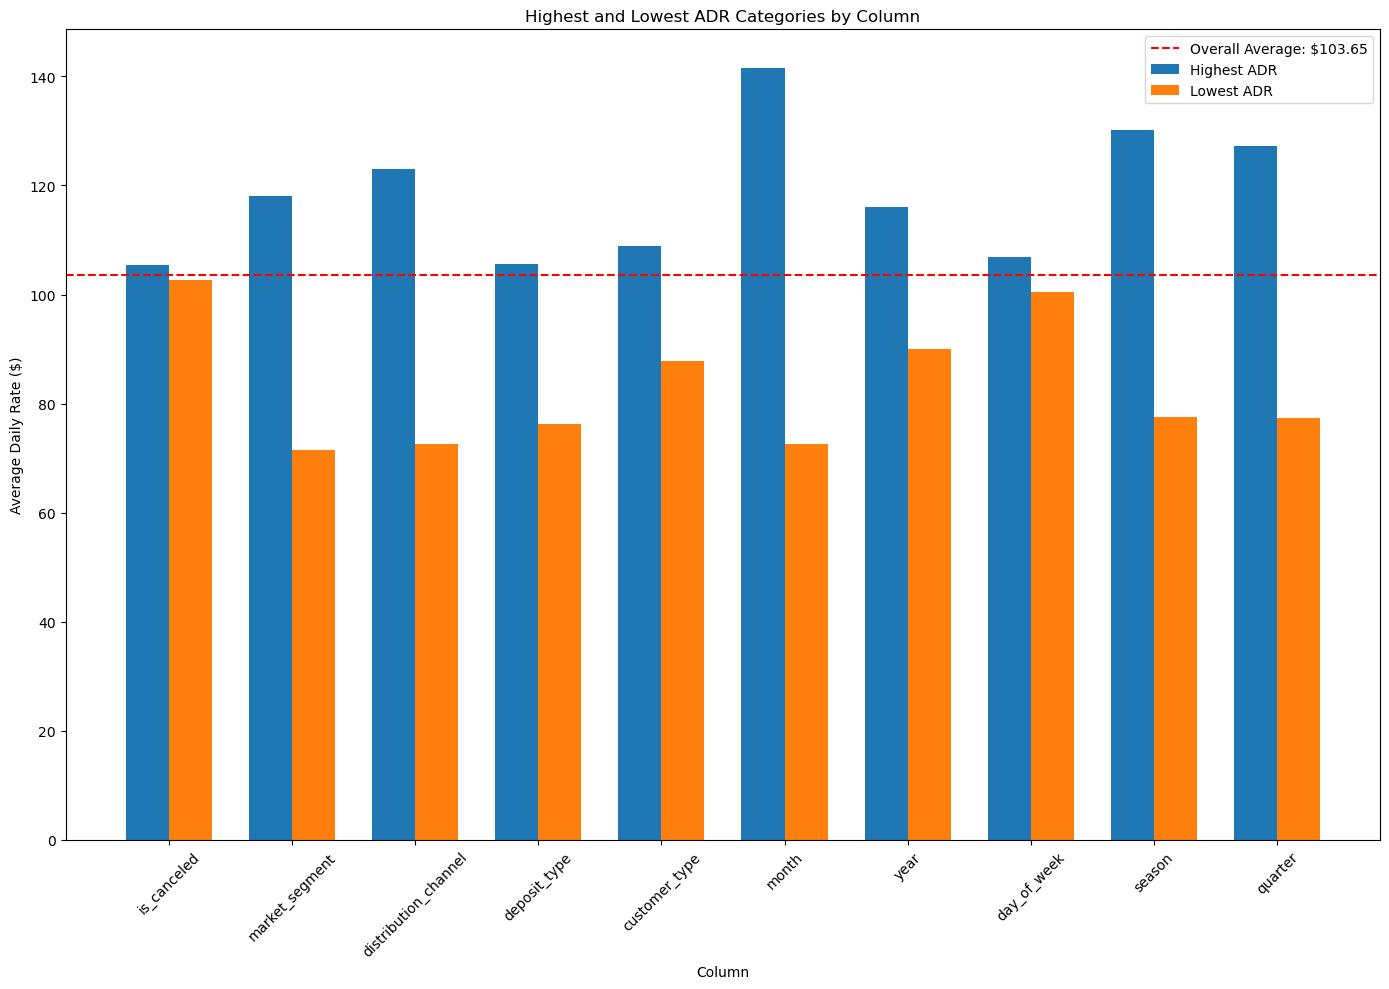


=== COMPREHENSIVE ACTION PLAN ===
Based on the analysis of ADR across multiple categories, here is a comprehensive action plan:

1. month Strategy:
   - Finding: August has $141.54 ADR vs. January with $72.57 ADR
   - Action: Implement seasonal pricing: increase rates during August and offer promotions during January to boost occupancy

2. season Strategy:
   - Finding: Summer has $130.19 ADR vs. Winter with $77.52 ADR
   - Action: Implement seasonal pricing strategy with higher rates during Summer and special offers during Winter

3. distribution_channel Strategy:
   - Finding: GDS has $123.0 ADR vs. Corporate with $72.59 ADR
   - Action: Focus marketing efforts on GDS channel; negotiate better rates or reduce dependency on Corporate

4. quarter Strategy:
   - Finding: 3 has $127.15 ADR vs. 1 with $77.36 ADR
   - Action: Develop quarterly business strategies with focused marketing during 1 to boost occupancy

5. market_segment Strategy:
   - Finding: Direct has $118.11 ADR vs. Corpor

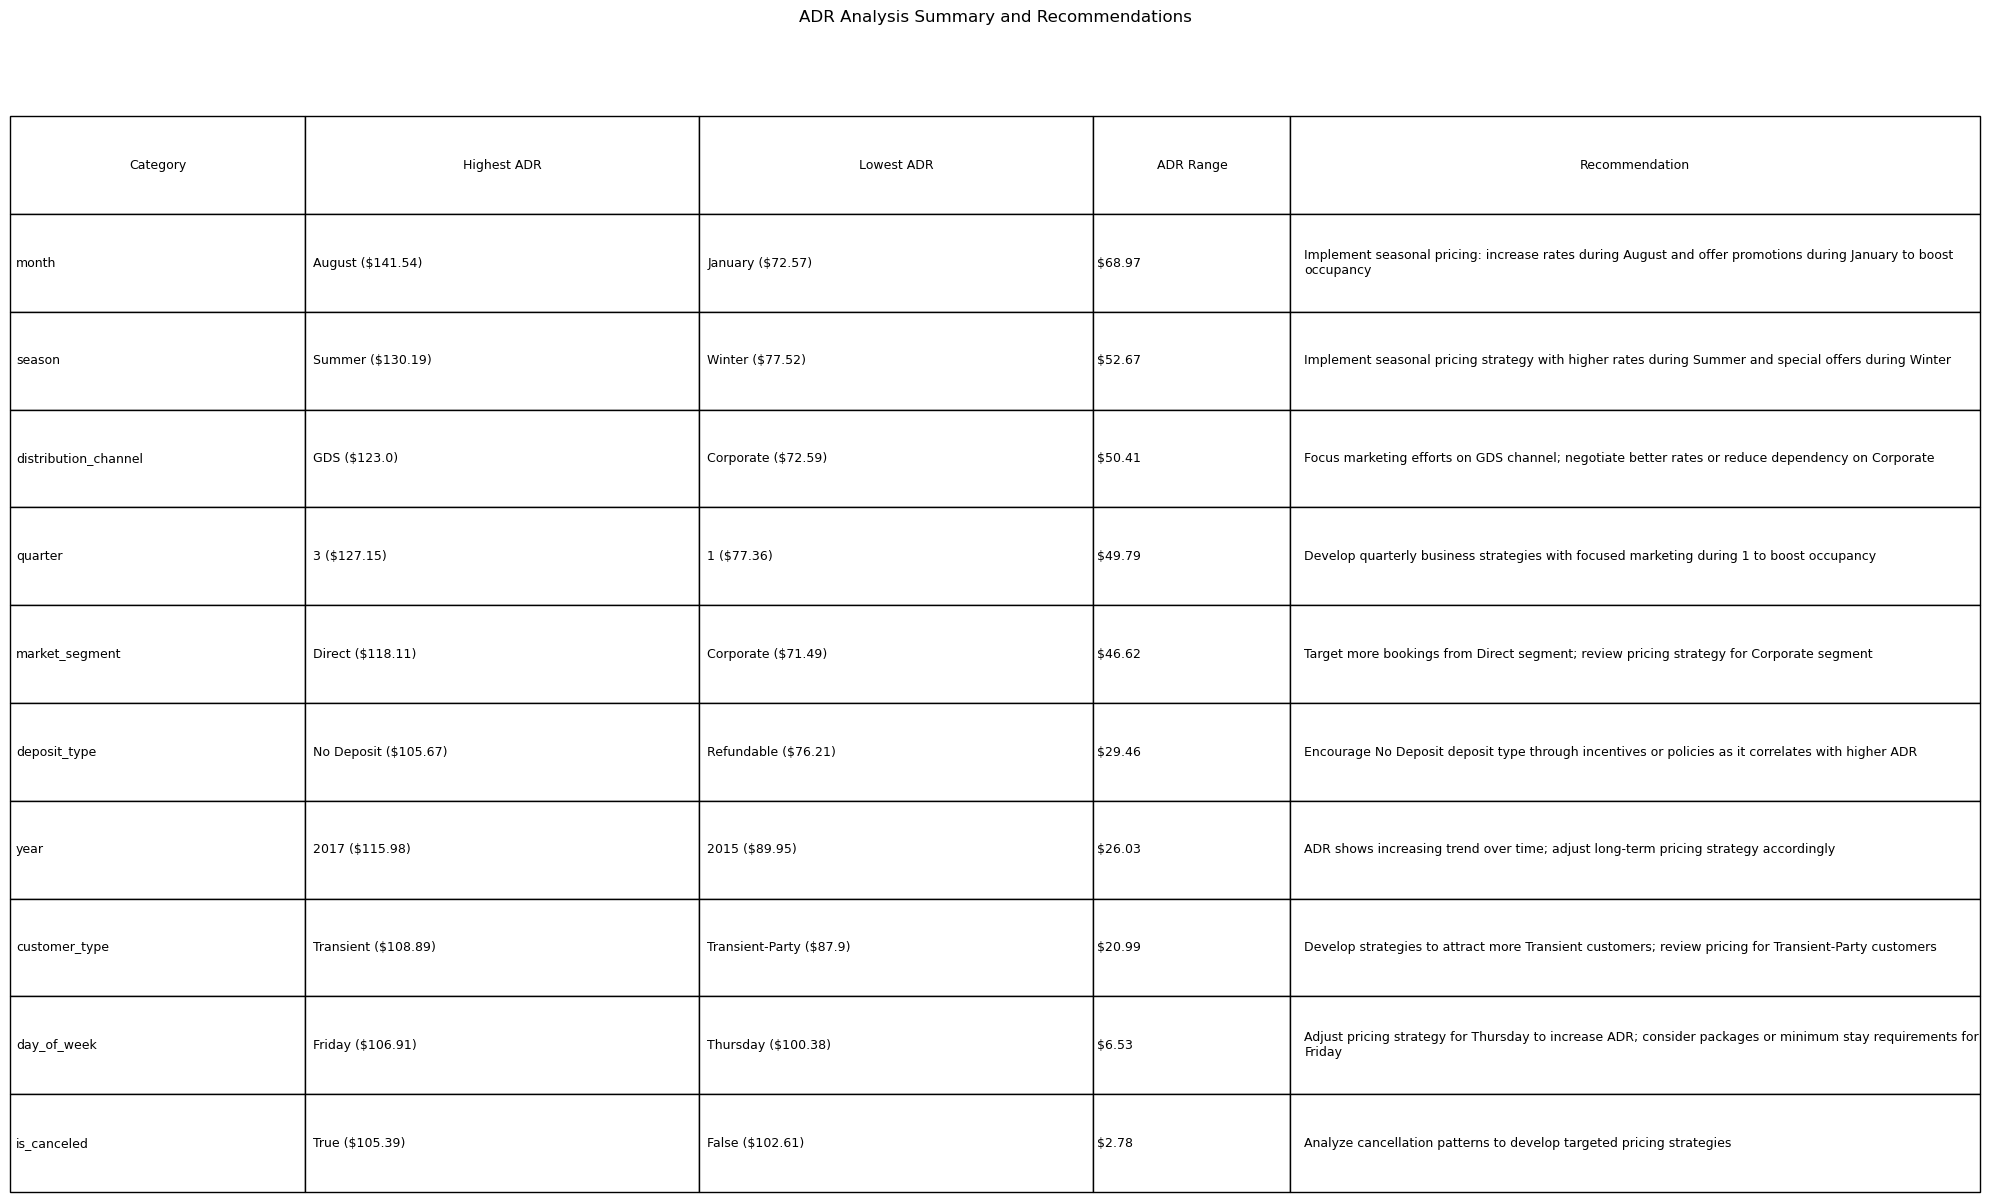

,Category,Highest ADR,Lowest ADR,ADR Range,Recommendation
1,MONTH,August ($141.54),January ($72.57),$68.97,Implement seasonal pricing: increase rates during August and offer promotions during January to boost occupancy
2,SEASON,Summer ($130.19),Winter ($77.52),$52.67,Implement seasonal pricing strategy with higher rates during Summer and special offers during Winter
3,DISTRIBUTION_CHANNEL,GDS ($123.00),Corporate ($72.59),$50.41,Focus marketing efforts on GDS channel; negotiate better rates or reduce dependency on Corporate
4,QUARTER,3 ($127.15),1 ($77.36),$49.79,Develop quarterly business strategies with focused marketing during 1 to boost occupancy
5,MARKET_SEGMENT,Direct ($118.11),Corporate ($71.49),$46.62,Target more bookings from Direct segment; review pricing strategy for Corporate segment
6,DEPOSIT_TYPE,No Deposit ($105.67),Refundable ($76.21),$29.46,Encourage No Deposit deposit type through incentives or policies as it correlates with higher ADR
7,YEAR,2017 ($115.98),2015 ($89.95),$26.03,ADR shows increasing trend over time; adjust long-term pricing strategy accordingly
8,CUSTOMER_TYPE,Transient ($108.89),Transient-Party ($87.90),$20.99,Develop strategies to attract more Transient customers; review pricing for Transient-Party customers
9,DAY_OF_WEEK,Friday ($106.91),Thursday ($100.38),$6.53,Adjust pricing strategy for Thursday to increase ADR; consider packages or minimum stay requirements for Friday
10,IS_CANCELED,True ($105.39),False ($102.61),$2.78,Analyze cancellation patterns to develop targeted pricing strategies


In [119]:
# Comprehensive summary of ADR analysis for all columns
print("=== COMPREHENSIVE ADR ANALYSIS SUMMARY ===\n")

# Create a DataFrame to store summary statistics
summary_data = []

# Function to analyze each column and provide recommendations
def analyze_column_impact(column_name):
    # Group by the column and calculate mean ADR
    grouped = df.groupby(column_name)['adr'].agg(['mean', 'count', 'std']).round(2)
    
    # Sort by mean ADR
    sorted_by_adr = grouped.sort_values('mean')
    
    # Get lowest and highest categories (safely)
    if len(sorted_by_adr) > 0:
        lowest_category = sorted_by_adr.index[0]
        lowest_adr = sorted_by_adr['mean'].iloc[0]
        
        highest_category = sorted_by_adr.index[-1]
        highest_adr = sorted_by_adr['mean'].iloc[-1]
        
        # Calculate percentage difference from overall average
        lowest_diff = ((lowest_adr - overall_adr_avg) / overall_adr_avg * 100).round(2)
        highest_diff = ((highest_adr - overall_adr_avg) / overall_adr_avg * 100).round(2)
        
        # Calculate impact range
        impact_range = highest_adr - lowest_adr
    else:
        lowest_category = "N/A"
        highest_category = "N/A"
        lowest_adr = 0
        highest_adr = 0
        lowest_diff = 0
        highest_diff = 0
        impact_range = 0
    
    # Calculate percentage of total bookings for each category
    grouped['percentage'] = (grouped['count'] / grouped['count'].sum() * 100).round(2)
    
    # Find the most common category
    most_common = grouped['count'].idxmax() if len(grouped) > 0 else "N/A"
    most_common_pct = grouped.loc[most_common, 'percentage'] if most_common != "N/A" else 0
    
    # Generate specific recommendations based on column and findings
    if column_name == 'is_canceled':
        # Check if we can safely compare the values
        if 0 in grouped.index and 1 in grouped.index:
            if grouped.loc[0, 'mean'] > grouped.loc[1, 'mean']:
                recommendation = "Consider investigating why non-canceled bookings have higher ADR - may indicate pricing strategy is effective"
            else:
                recommendation = "Implement strategies to reduce cancellations, especially for high-value bookings"
        else:
            recommendation = "Analyze cancellation patterns to develop targeted pricing strategies"
            
    elif column_name == 'month':
        recommendation = f"Implement seasonal pricing: increase rates during {highest_category} and offer promotions during {lowest_category} to boost occupancy"
            
    elif column_name == 'day_of_week':
        recommendation = f"Adjust pricing strategy for {lowest_category} to increase ADR; consider packages or minimum stay requirements for {highest_category}"
            
    elif column_name == 'market_segment':
        recommendation = f"Target more bookings from {highest_category} segment; review pricing strategy for {lowest_category} segment"
            
    elif column_name == 'distribution_channel':
        recommendation = f"Focus marketing efforts on {highest_category} channel; negotiate better rates or reduce dependency on {lowest_category}"
            
    elif column_name == 'deposit_type':
        recommendation = f"Encourage {highest_category} deposit type through incentives or policies as it correlates with higher ADR"
            
    elif column_name == 'customer_type':
        recommendation = f"Develop strategies to attract more {highest_category} customers; review pricing for {lowest_category} customers"
            
    elif column_name == 'year':
        years_list = sorted(grouped.index)
        if len(years_list) >= 2:
            latest_year = years_list[-1]
            earliest_year = years_list[0]
            year_trend = "increasing" if grouped.loc[latest_year, 'mean'] > grouped.loc[earliest_year, 'mean'] else "decreasing"
            recommendation = f"ADR shows {year_trend} trend over time; adjust long-term pricing strategy accordingly"
        else:
            recommendation = "Insufficient year data for trend analysis"
            
    elif column_name == 'season':
        recommendation = f"Implement seasonal pricing strategy with higher rates during {highest_category} and special offers during {lowest_category}"
            
    elif column_name == 'quarter':
        recommendation = f"Develop quarterly business strategies with focused marketing during {lowest_category} to boost occupancy"
    else:
        recommendation = "Review pricing strategy based on category performance"
    
    # Summarize findings
    print(f"\n--- {column_name.upper()} ---")
    print(f"Lowest ADR: {lowest_category} (${lowest_adr}, {lowest_diff}% from average)")
    print(f"Highest ADR: {highest_category} (${highest_adr}, {highest_diff}% from average)")
    print(f"ADR Range: ${impact_range}")
    print(f"Most common: {most_common} ({most_common_pct}% of bookings)")
    print(f"Recommendation: {recommendation}")
    
    # Add to summary data
    summary_data.append({
        'Column': column_name,
        'Lowest_ADR_Category': lowest_category,
        'Lowest_ADR': lowest_adr,
        'Lowest_ADR_Pct': lowest_diff,
        'Highest_ADR_Category': highest_category,
        'Highest_ADR': highest_adr,
        'Highest_ADR_Pct': highest_diff,
        'ADR_Range': impact_range,
        'Most_Common': most_common,
        'Most_Common_Pct': most_common_pct,
        'Recommendation': recommendation
    })
    
    # Return data for detailed visualization
    return grouped

# Analyze all columns
all_columns = standard_columns + time_columns
column_data = {}

for column in all_columns:
    column_data[column] = analyze_column_impact(column)

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Create a visualization summary of highest and lowest categories for each column
plt.figure(figsize=(14, 10))
plt.title('Highest and Lowest ADR Categories by Column')

# Prepare data for plotting
columns = summary_df['Column']
highest_adr = summary_df['Highest_ADR']
lowest_adr = summary_df['Lowest_ADR']

# Set up bar positions
x = np.arange(len(columns))
width = 0.35

# Plot bars
plt.bar(x - width/2, highest_adr, width, label='Highest ADR')
plt.bar(x + width/2, lowest_adr, width, label='Lowest ADR')

# Add labels and formatting
plt.xlabel('Column')
plt.ylabel('Average Daily Rate ($)')
plt.xticks(x, columns, rotation=45)
plt.axhline(y=overall_adr_avg, color='r', linestyle='--', label=f'Overall Average: ${overall_adr_avg:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Create a comprehensive action plan based on all findings
print("\n=== COMPREHENSIVE ACTION PLAN ===")
print("Based on the analysis of ADR across multiple categories, here is a comprehensive action plan:")

# Sort by ADR impact range to prioritize actions
summary_df = summary_df.sort_values('ADR_Range', ascending=False)
sorted_recommendations = summary_df

for i, row in enumerate(summary_df.iterrows()):
    idx, row_data = row
    print(f"\n{i+1}. {row_data['Column']} Strategy:")
    print(f"   - Finding: {row_data['Highest_ADR_Category']} has ${row_data['Highest_ADR']} ADR vs. {row_data['Lowest_ADR_Category']} with ${row_data['Lowest_ADR']} ADR")
    print(f"   - Action: {row_data['Recommendation']}")

# Create table visualization of recommendations
plt.figure(figsize=(20, 12))  # Increased figure size
plt.axis('off')
table_data = []
table_columns = ['Category', 'Highest ADR', 'Lowest ADR', 'ADR Range', 'Recommendation']

for idx, row in summary_df.iterrows():
    table_data.append([
        row['Column'],
        f"{row['Highest_ADR_Category']} (${row['Highest_ADR']})",
        f"{row['Lowest_ADR_Category']} (${row['Lowest_ADR']})",
        f"${row['ADR_Range']:.2f}",
        row['Recommendation']
    ])

# Create the table with adjusted parameters
table = plt.table(
    cellText=table_data,
    colLabels=table_columns,
    cellLoc='left',  # Align text to the left
    loc='center',
    bbox=[0, 0, 1, 1],
    colWidths=[0.15, 0.2, 0.2, 0.1, 0.35]  # Adjust column widths
)

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)  # Slightly smaller font size
table.scale(1.2, 2)  # Increased row height

# Auto-wrap text in cells
for cell in table._cells:
    table._cells[cell].set_text_props(wrap=True)
    table._cells[cell].set_height(0.1)  # Increased cell height
    
    # Add padding to cells
    table._cells[cell].PAD = 0.02

plt.title('ADR Analysis Summary and Recommendations', y=1.08)
plt.tight_layout()
plt.show()

# Create a more detailed DataFrame for display
detailed_recommendations = pd.DataFrame({
    'Category': sorted_recommendations['Column'].str.upper(),
    'Highest ADR': sorted_recommendations.apply(lambda x: f"{x['Highest_ADR_Category']} (${x['Highest_ADR']:.2f})", axis=1),
    'Lowest ADR': sorted_recommendations.apply(lambda x: f"{x['Lowest_ADR_Category']} (${x['Lowest_ADR']:.2f})", axis=1),
    'ADR Range': sorted_recommendations['ADR_Range'].apply(lambda x: f"${x:.2f}"),
    'Recommendation': sorted_recommendations['Recommendation']
})

# Reset index to show row numbers starting from 1
detailed_recommendations.index = range(1, len(detailed_recommendations) + 1)

# Display the table with styling
from IPython.display import display, HTML

# Apply styling to the DataFrame
styled_df = detailed_recommendations.style\
    .set_properties(**{
        'background-color': '#000000',  # Black background
        'color': '#ffffff',  # White text
        'border-color': '#333333',
        'border-style': 'solid',
        'border-width': '1px',
        'padding': '10px',
        'text-align': 'left'
    })\
    .set_table_styles([
        {'selector': 'th',  # Headers stay the same
         'props': [('background-color', '#4CAF50'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('padding', '10px'),
                  ('text-align', 'left')]},
        {'selector': 'tr:hover',
         'props': [('background-color', '#1a1a1a')]},  # Darker gray on hover
    ])\
    .set_caption('Detailed ADR Analysis and Recommendations')

# Display the styled table
display(styled_df)

## Conclusions Part 1: 

* Implement seasonal pricing: increase rates during August and offer promotions during January to boost occupancy.

* Focus marketing efforts on GDS channel (Travel agencies and Touroperatos); negotiate better rates, and possibly avoid coporate contracts or increase pricing for this ones if it is a obligation in the contract.

* Target more bookings from the Direct segment avoiding dependency on Travel Agents on Touroperators, since Direct bookings provide a much higher revenue: Marketing strategies, advertising etc... 

* Control pricing on Refundable, the cancellation rate on this is under the average cancellation average (22% vds 37%) but the pricing for refundable bookings should be higher and removed from bookings for high season (Summer).

* Adjust pricing strategy for Thursday to increase ADR; Consider packages or minimum stay requirements for Friday, to boost the weekend as a whole. The price variations in the City Hotel specially could be adapted to the different seasons. 




Dataset Shape: (118087, 30)

ADR Statistics:
count    118087.000000
mean        103.650920
std          46.410053
min           0.260000
25%          71.345000
50%          95.000000
75%         126.000000
max         510.000000
Name: adr, dtype: float64

Null values in ADR: 0


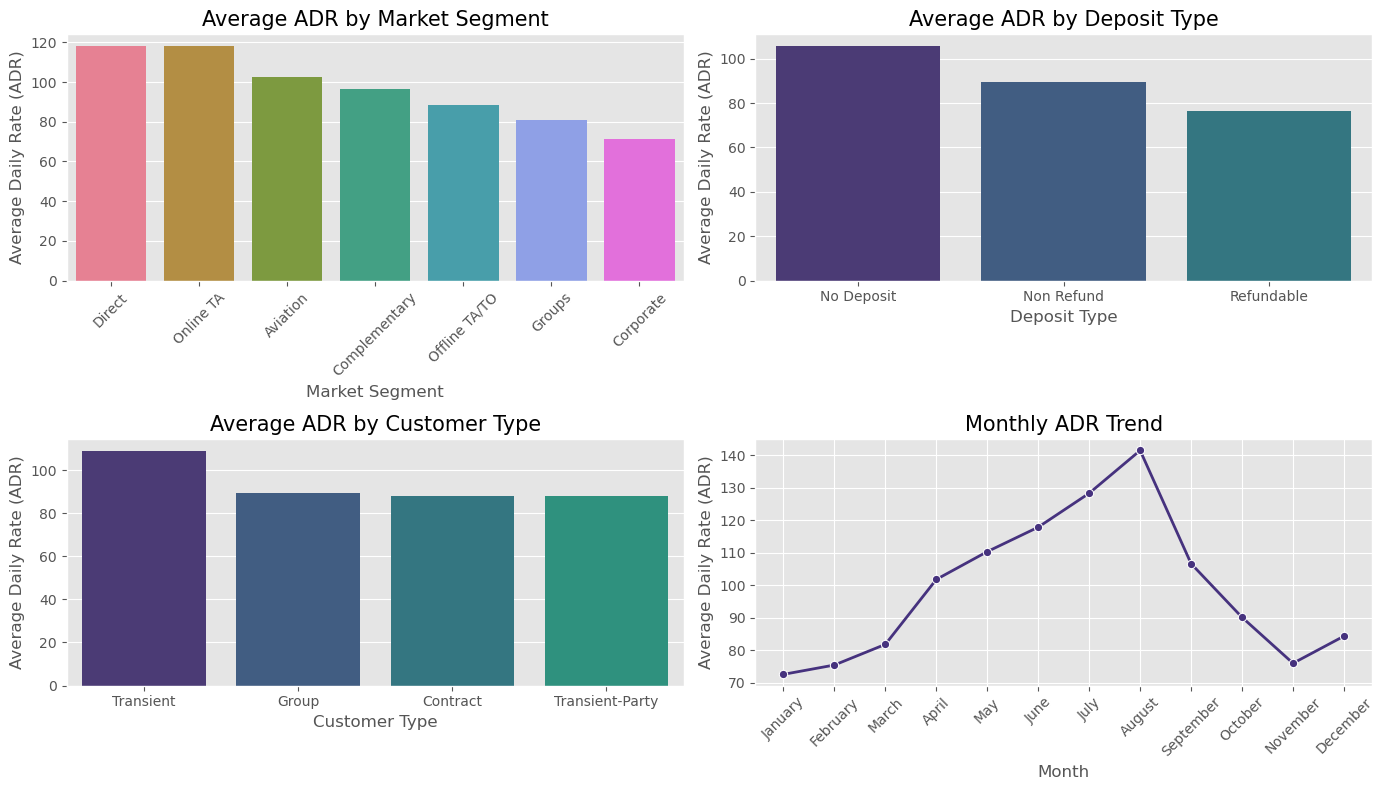

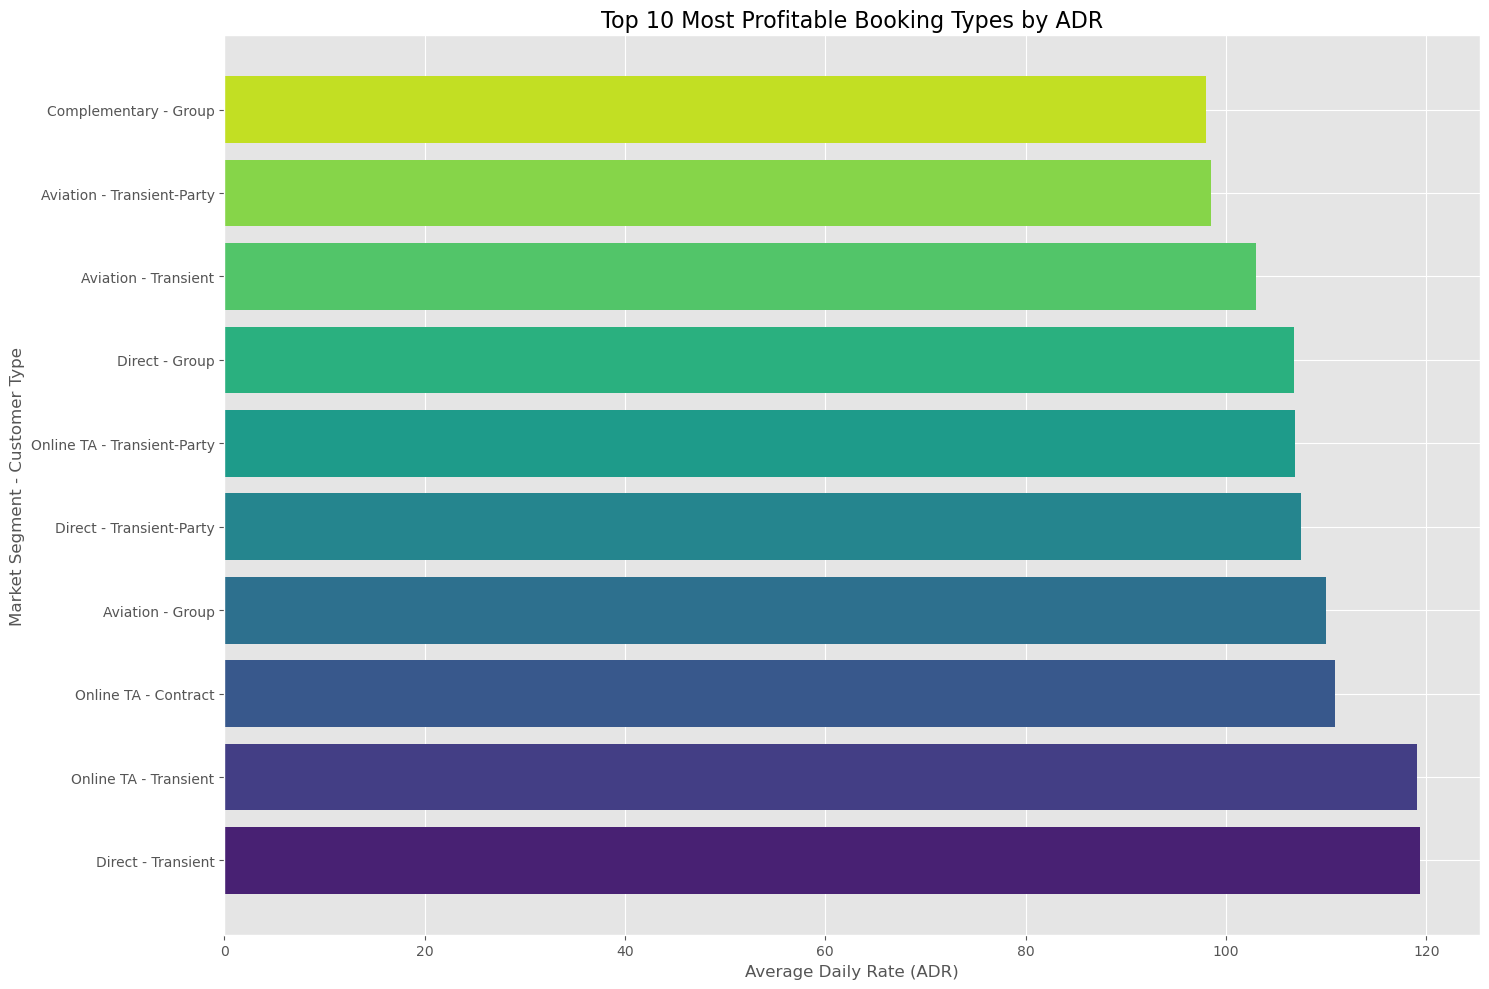

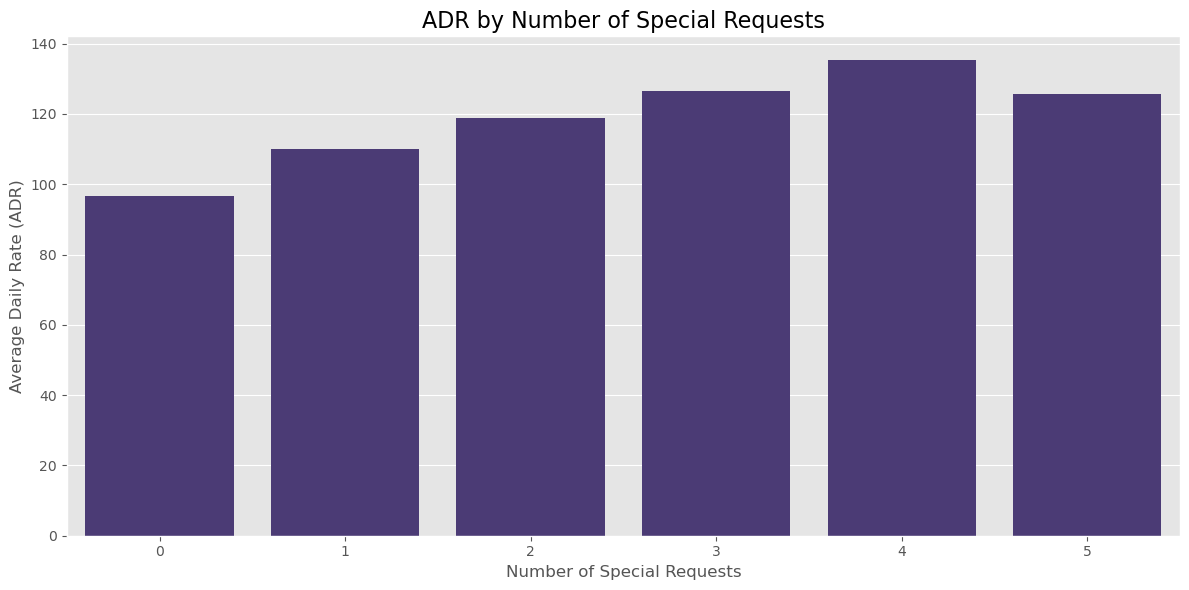

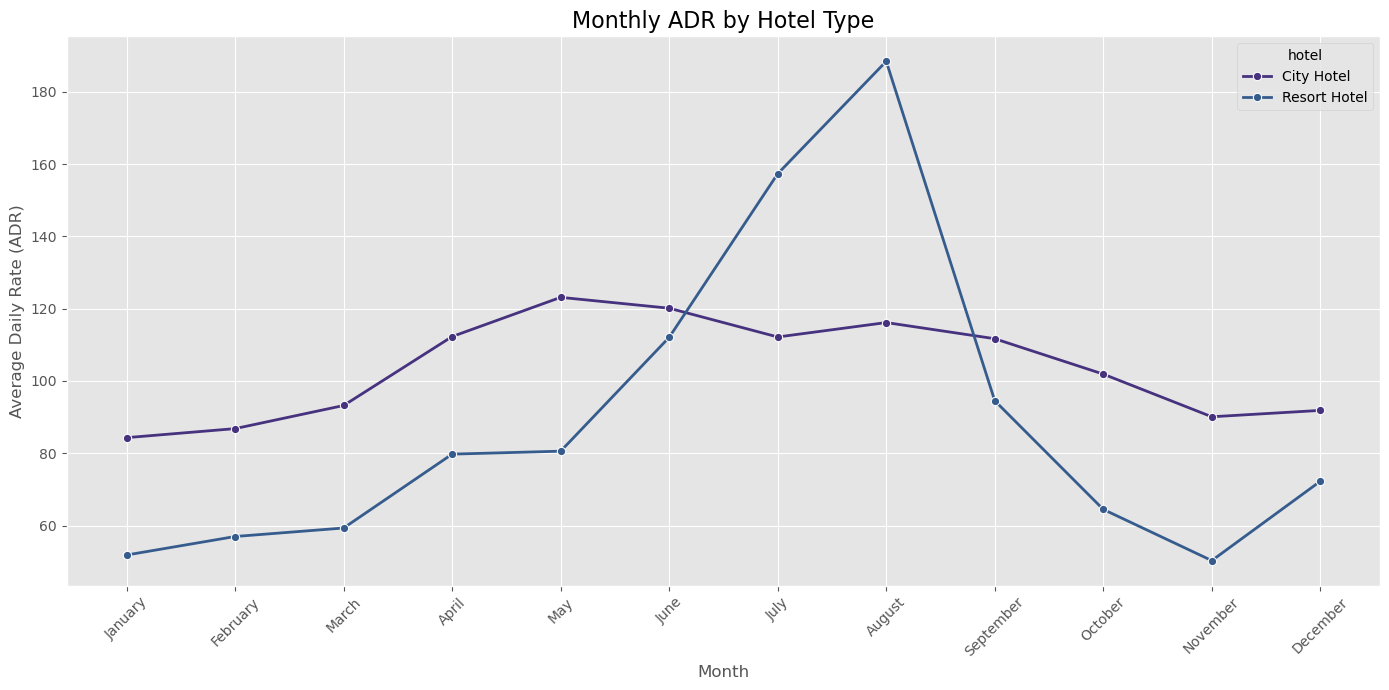

In [120]:

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("viridis")

# Load the data
df = pd.read_csv('hotel_bookings_clean.csv', parse_dates=['arrival_date'])

# Basic exploration
print(f"Dataset Shape: {df.shape}")
print(f"\nADR Statistics:")
print(df['adr'].describe())
print(f"\nNull values in ADR: {df['adr'].isnull().sum()}")

# Calculate total stay length
df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# ----- ANALYSIS BY INDIVIDUAL FACTORS -----

# 1. ADR by hotel type
adr_hotel = df.groupby('hotel', observed=True)['adr'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)

# 2. ADR by market segment
adr_market = df.groupby('market_segment', observed=True)['adr'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)

# 3. ADR by customer type
adr_customer = df.groupby('customer_type', observed=True)['adr'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)

# 4. ADR by deposit type
adr_deposit = df.groupby('deposit_type', observed=True)['adr'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)

# 5. ADR by distribution channel
adr_channel = df.groupby('distribution_channel', observed=True)['adr'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)

# 6. ADR by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=month_order, ordered=True)
adr_month = df.groupby('arrival_date_month', observed=True)['adr'].agg(['mean', 'median', 'count', 'std'])

# 7. ADR by special requests
adr_requests = df.groupby('total_of_special_requests', observed=True)['adr'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)

# 8. ADR by length of stay
adr_stay = df.groupby('total_stay', observed=True)['adr'].agg(['mean', 'median', 'count', 'std'])
# Filter out stays with few bookings for clearer visualization
adr_stay_filtered = adr_stay[adr_stay['count'] > 100].sort_values('mean', ascending=False)

# ----- ANALYSIS BY COMBINATIONS OF FACTORS -----

# 9. ADR by hotel and market segment
adr_hotel_market = df.groupby(['hotel', 'market_segment'])['adr'].agg(['mean', 'count']).sort_values('mean', ascending=False)

# 10. ADR by market segment and customer type
adr_market_customer = df.groupby(['market_segment', 'customer_type'])['adr'].agg(['mean', 'count']).sort_values('mean', ascending=False)

# 11. ADR by market segment and deposit type
adr_market_deposit = df.groupby(['market_segment', 'deposit_type'])['adr'].agg(['mean', 'count']).sort_values('mean', ascending=False)
# ----- VISUALIZATIONS -----

# Set up the figure size for all plots
plt.figure(figsize=(14, 8))

# 1. Market Segment Chart
plt.subplot(2, 2, 1)
sns.barplot(x=adr_market.index, y=adr_market['mean'], hue=adr_market.index, legend=False)
plt.title('Average ADR by Market Segment', fontsize=15)
plt.xlabel('Market Segment')
plt.ylabel('Average Daily Rate (ADR)')
plt.xticks(rotation=45)

# 2. Deposit Type Chart
plt.subplot(2, 2, 2)
sns.barplot(x=adr_deposit.index, y=adr_deposit['mean'], hue=adr_deposit.index, legend=False)
plt.title('Average ADR by Deposit Type', fontsize=15)
plt.xlabel('Deposit Type')
plt.ylabel('Average Daily Rate (ADR)')

# 3. Customer Type Chart
plt.subplot(2, 2, 3)
sns.barplot(x=adr_customer.index, y=adr_customer['mean'], hue=adr_customer.index, legend=False)
plt.title('Average ADR by Customer Type', fontsize=15)
plt.xlabel('Customer Type')
plt.ylabel('Average Daily Rate (ADR)')

# 4. Monthly Trend Chart
plt.subplot(2, 2, 4)
sns.lineplot(x=adr_month.index, y=adr_month['mean'], marker='o', linewidth=2)
plt.title('Monthly ADR Trend', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Average Daily Rate (ADR)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Combinations analysis visualization
plt.figure(figsize=(15, 10))

# Top 10 most profitable combinations
top_combos = adr_market_customer.head(10).reset_index()
plt.barh(y=[f"{m} - {c}" for m, c in zip(top_combos['market_segment'], top_combos['customer_type'])], 
         width=top_combos['mean'],
         color=sns.color_palette('viridis', 10))
plt.title('Top 10 Most Profitable Booking Types by ADR', fontsize=16)
plt.xlabel('Average Daily Rate (ADR)')
plt.ylabel('Market Segment - Customer Type')
plt.tight_layout()
plt.show()

# Special requests correlation with ADR
plt.figure(figsize=(12, 6))
sns.barplot(x=adr_requests.index, y=adr_requests['mean'])
plt.title('ADR by Number of Special Requests', fontsize=16)
plt.xlabel('Number of Special Requests')
plt.ylabel('Average Daily Rate (ADR)')
plt.tight_layout()
plt.show()

# Monthly ADR by hotel type
monthly_hotel = df.groupby(['hotel', 'arrival_date_month'], observed=True)['adr'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_hotel, x='arrival_date_month', y='adr', hue='hotel', marker='o', linewidth=2)
plt.title('Monthly ADR by Hotel Type', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Daily Rate (ADR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## What if we include the cancellations in the mix?


8. ADR by Cancellation Status:
   is_canceled        mean  median  count        std
0        False  102.612350    95.0  73973  46.864696
1         True  105.392455    97.0  44114  45.584969

Cancellation Rate by Market Segment (%):
  market_segment  cancellation_rate
4         Groups          61.217981
6      Online TA          36.967264
5  Offline TA/TO          34.467092
0       Aviation          22.077922
2      Corporate          19.319082
3         Direct          15.588642
1  Complementary          12.201964

Cancellation Rate by Deposit Type (%):
  deposit_type  cancellation_rate
1   Non Refund          99.361790
0   No Deposit          28.638743
2   Refundable          22.222222

Market Segments by Expected ADR (accounting for cancellations):
  market_segment  cancellation_rate     avg_adr  expected_adr
3         Direct          15.588642  118.110782     99.698915
1  Complementary          12.201964   96.624222     84.834169
0       Aviation          22.077922  102.743203     

/tmp/ipykernel_124350/1427532929.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



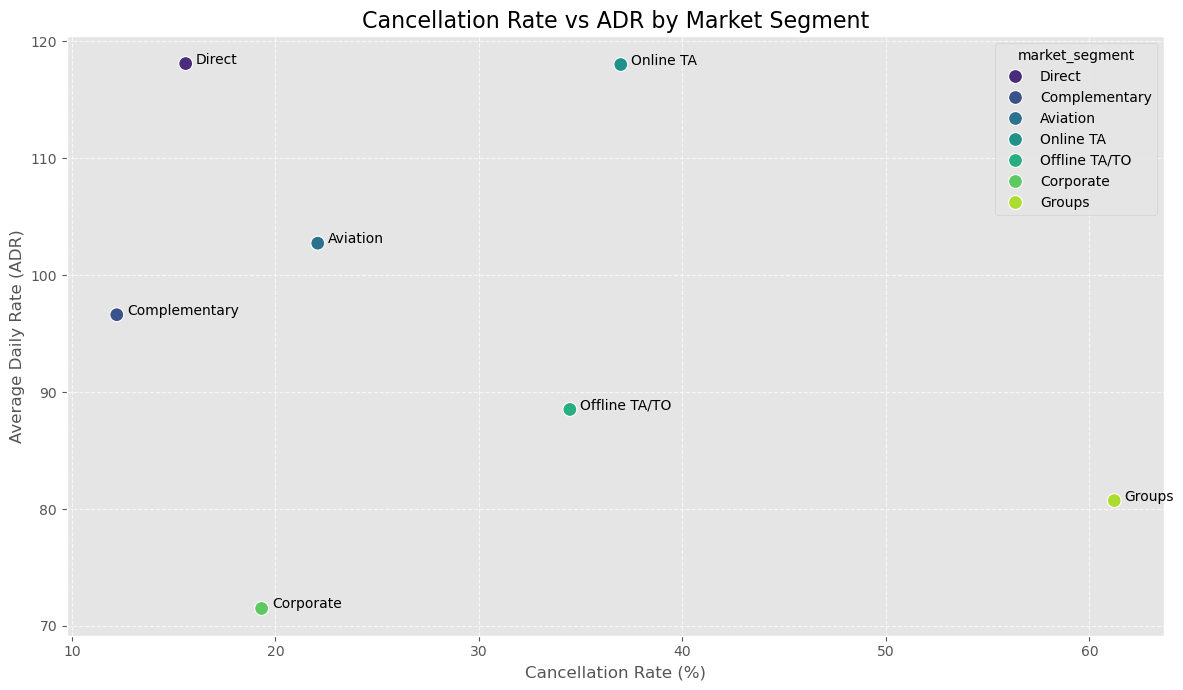

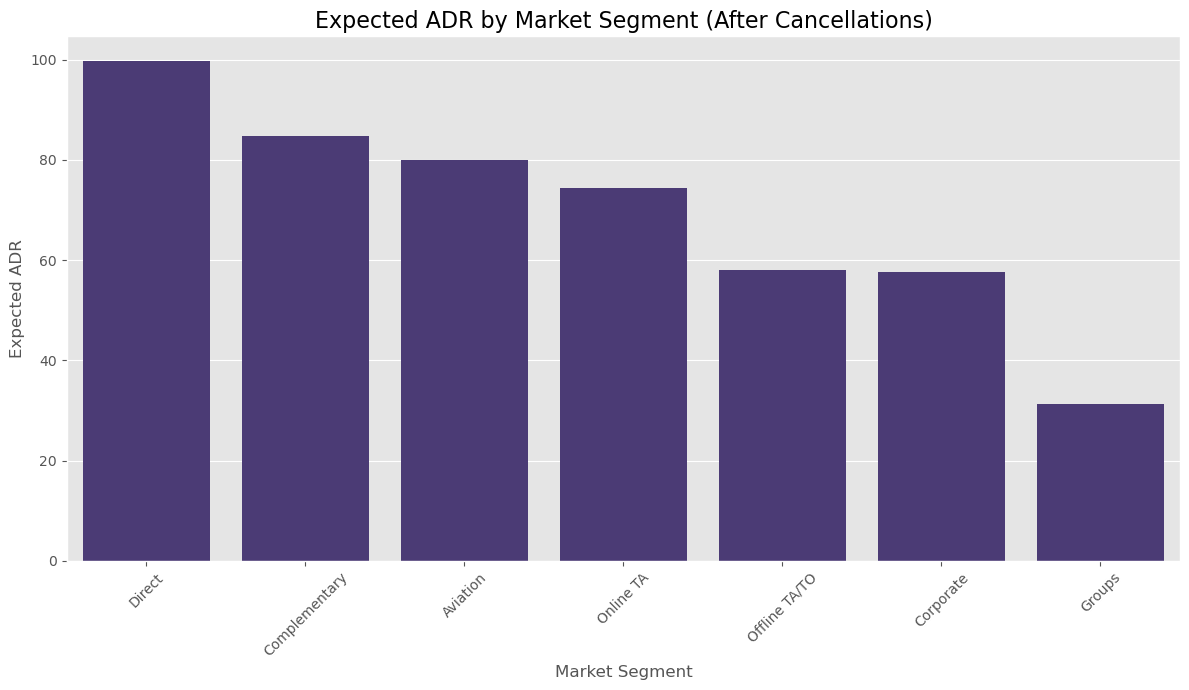

In [121]:
# ----- CANCELLATION ANALYSIS -----

# 1. ADR by cancellation status
adr_canceled = df.groupby('is_canceled')['adr'].agg(['mean', 'median', 'count', 'std']).reset_index()
print("\n8. ADR by Cancellation Status:")
print(adr_canceled)

# 2. Cancellation rate by market segment
cancel_by_segment = df.groupby('market_segment')['is_canceled'].mean().reset_index()
cancel_by_segment.columns = ['market_segment', 'cancellation_rate']
cancel_by_segment['cancellation_rate'] = cancel_by_segment['cancellation_rate'] * 100  # Convert to percentage
cancel_by_segment = cancel_by_segment.sort_values('cancellation_rate', ascending=False)
print("\nCancellation Rate by Market Segment (%):")
print(cancel_by_segment)

# 3. Cancellation rate by deposit type
cancel_by_deposit = df.groupby('deposit_type')['is_canceled'].mean().reset_index()
cancel_by_deposit.columns = ['deposit_type', 'cancellation_rate']
cancel_by_deposit['cancellation_rate'] = cancel_by_deposit['cancellation_rate'] * 100  # Convert to percentage
cancel_by_deposit = cancel_by_deposit.sort_values('cancellation_rate', ascending=False)
print("\nCancellation Rate by Deposit Type (%):")
print(cancel_by_deposit)

# 4. ADR and cancellation rate combined analysis
segment_cancel_adr = df.groupby('market_segment').agg({
    'is_canceled': 'mean',
    'adr': 'mean'
}).reset_index()
segment_cancel_adr.columns = ['market_segment', 'cancellation_rate', 'avg_adr']
segment_cancel_adr['cancellation_rate'] = segment_cancel_adr['cancellation_rate'] * 100
segment_cancel_adr['expected_adr'] = segment_cancel_adr['avg_adr'] * (1 - segment_cancel_adr['cancellation_rate']/100)
segment_cancel_adr = segment_cancel_adr.sort_values('expected_adr', ascending=False)
print("\nMarket Segments by Expected ADR (accounting for cancellations):")
print(segment_cancel_adr)

# 5. Lead time vs cancellation analysis
df['lead_time_bucket'] = pd.cut(df['lead_time'], bins=[0, 30, 90, 180, 365, df['lead_time'].max()], 
                              labels=['0-30 days', '31-90 days', '91-180 days', '181-365 days', '>365 days'])
lead_cancel = df.groupby('lead_time_bucket').agg({
    'is_canceled': 'mean',
    'adr': 'mean'
}).reset_index()
lead_cancel.columns = ['lead_time_bucket', 'cancellation_rate', 'avg_adr']
lead_cancel['cancellation_rate'] = lead_cancel['cancellation_rate'] * 100
lead_cancel['expected_adr'] = lead_cancel['avg_adr'] * (1 - lead_cancel['cancellation_rate']/100)
print("\nLead Time vs Cancellation Rate and ADR:")
print(lead_cancel)

# ----- VISUALIZATIONS FOR CANCELLATION ANALYSIS -----

""" # 1. ADR by cancellation status
plt.figure(figsize=(10, 6))
sns.barplot(x=adr_canceled['is_canceled'].map({True: 'Canceled', False: 'Not Canceled'}), 
            y=adr_canceled['mean'])
plt.title('ADR by Cancellation Status', fontsize=16)
plt.xlabel('Booking Status')
plt.ylabel('Average Daily Rate (ADR)')
plt.tight_layout()
plt.show() """

# 2. Cancellation rate vs ADR by market segment
plt.figure(figsize=(12, 7))
sns.scatterplot(data=segment_cancel_adr, x='cancellation_rate', y='avg_adr', s=100, 
               hue='market_segment', palette='viridis')
for i, row in segment_cancel_adr.iterrows():
    plt.annotate(row['market_segment'], (row['cancellation_rate']+0.5, row['avg_adr']), fontsize=10)
plt.title('Cancellation Rate vs ADR by Market Segment', fontsize=16)
plt.xlabel('Cancellation Rate (%)')
plt.ylabel('Average Daily Rate (ADR)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Expected ADR (after accounting for cancellations)
plt.figure(figsize=(12, 7))
sns.barplot(x=segment_cancel_adr['market_segment'], y=segment_cancel_adr['expected_adr'])
plt.title('Expected ADR by Market Segment (After Cancellations)', fontsize=16)
plt.xlabel('Market Segment')
plt.ylabel('Expected ADR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Additional recommendations regarding cancellations:
1. Implement stricter cancellation policies for segments with high cancellation rates
2. Consider overbooking strategies based on historical cancellation patterns
3. Offer incentives for early bookings with non-refundable options
4. Target marketing toward segments with lower cancellation rates
5. Analyze lead time patterns to optimize booking acceptance strategies
6. Focus on market segments with the highest expected ADR after cancellations: Direct and Complementary

## Summary :
    Pricing & Seasonality: Adjust rates seasonally (higher in August, promotions in January) while tightening refundable policies in peak seasons to maximize revenue.

    Channel Strategy: Prioritize GDS (negotiate better rates) and aggressively target Direct bookings (higher revenue) to balance dependency on intermediaries.

    Cancellation Management: Stricter policies for high-cancellation segments combined with overbooking strategies and non-refundable incentives to optimize occupancy.

    ADR Optimization: Raise Thursday pricing and introduce Friday packages/minimum stays to boost weekend revenue while focusing on high-ADR segments (Direct/Complementary).

    Marketing Focus: Align campaigns with low-cancellation, high-ADR segments and leverage lead time analysis to refine booking acceptance timing.